# Identifying Fraudulent Job Postings with Machine Learning
## Alexandra Stepanenko, MSc Data Science

Data source: https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction

Dataset description: "This dataset contains 18K job descriptions out of which about 800 are fake. The data consists of both textual information and meta-information about the jobs. The dataset can be used to create classification models which can learn the job descriptions which are fraudulent."

In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import sys
import sklearn
import re
import string
import spacy
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from gensim.models import Phrases
from gensim.models.word2vec import Word2Vec
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import chi2
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle 
from numpy.random import seed
import tensorflow as tf
from keras.models import Model
from tensorflow.keras import layers, Input, regularizers, optimizers, metrics
from tensorflow.keras.callbacks import EarlyStopping
import random
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Import 

We will also briefly explore the structure of the data:

In [3]:
# Import the data
jobs = pd.read_csv("Data/fake_job_postings.csv")

jobs.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [ ]:
jobs.shape

(17880, 18)

In [ ]:
jobs.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
jobs.dtypes

job_id                  int64
title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
dtype: object

'fraudulent' is our binary target variable, which we can see is class imbalanced:

In [ ]:
jobs['fraudulent'].value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

# Training & test dataset split

In [ ]:
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=100)

for train_index, test_index in strat_split.split(jobs, jobs['fraudulent']):
    # Train and test datasets with no preprocessing
    train_npp = jobs.loc[train_index]
    test_npp = jobs.loc[test_index]
    
# Reset indicies
train_npp.reset_index(inplace = True, drop = True)
test_npp.reset_index(inplace = True, drop = True)

In [ ]:
train_npp.shape

(12516, 18)

In [ ]:
test_npp.shape

(5364, 18)

We can see test and train have an equal distribution of fraudulent and non-fraudulent records:

In [ ]:
train_npp.value_counts('fraudulent')/len(train_npp)*100

fraudulent
0    95.158198
1     4.841802
dtype: float64

In [ ]:
test_npp.value_counts('fraudulent')/len(test_npp)*100

fraudulent
0    95.152871
1     4.847129
dtype: float64

# Data exploration

Let's look at number of unique values and percentage of missing values for each feature:

In [ ]:
jobs_valcount = pd.DataFrame(columns=['Column', 'Unique values', 'Percentage missing'])
i = 0

for col in jobs:
    jobs_valcount.loc[i, 'Column'] = col
    jobs_valcount.loc[i, 'Unique values'] = train_npp[col].nunique()
    jobs_valcount.loc[i, 'Percentage missing'] = round(train_npp[col].isna().sum()/len(train_npp)*100, 3)
    i += 1
    
jobs_valcount

,Column,Unique values,Percentage missing
0,job_id,12516,0.0
1,title,8371,0.0
2,location,2567,1.854
3,department,1073,64.382
4,salary_range,717,83.981
5,company_profile,1528,18.552
6,description,10695,0.008
7,requirements,8654,15.284
8,benefits,4666,40.788
9,telecommuting,2,0.0


From the combination of viewing the data, dtype within the dataframe and number of unique values, we can assign data types for the features and begin exploring whether they may be predictive.

### Defining plotting functions

In [ ]:
def plot_countplots(col):
    #sort
    jobs_s = train_npp.sort_values(col)
    
    fig = plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    ax = sns.countplot(data = jobs_s[jobs_s['fraudulent'] == 0], x = col)
    ax.set_title('Genuine postings', size=16)

    plt.subplot(1, 2, 2)
    ax = sns.countplot(data = jobs_s[jobs_s['fraudulent'] == 1], x = col)
    ax.set_title('Fraudulent postings', size=16)

    plt.show()

In [ ]:
def plot_countplots_bar(col, figheight = 10):
    #sort
    jobs_s = train_npp.sort_values(col)
    
    fig = plt.figure(figsize=(16, figheight))
    plt.subplot(2, 1, 1)
    ax = sns.countplot(data = jobs_s[jobs_s['fraudulent'] == 0], y = col)
    ax.set_title('Genuine postings', size=16)

    plt.subplot(2, 1, 2)
    ax = sns.countplot(data = jobs_s[jobs_s['fraudulent'] == 1], y = col)
    ax.set_title('Fraudulent postings', size=16)

    plt.show()

In [ ]:
def plot_countplots_bar_lim(col, figheight = 10, catlim = 10):
    #sort
    jobs_s = train_npp.sort_values(col)
    
    fig = plt.figure(figsize=(16, figheight))
    plt.subplot(2, 1, 1)
    ax = sns.countplot(data = jobs_s[jobs_s['fraudulent'] == 0], y = col, color='royalblue',
                       order = jobs_s[col][jobs_s['fraudulent'] == 0].value_counts().iloc[:catlim].index)
    ax.set_title('Genuine postings - top ' + str(catlim) + ' categories', size=16)

    plt.subplot(2, 1, 2)
    ax = sns.countplot(data = jobs_s[jobs_s['fraudulent'] == 1], y = col, color='royalblue',
                      order = jobs_s[col][jobs_s['fraudulent'] == 1].value_counts().iloc[:catlim].index)
    ax.set_title('Fraudulent postings - top ' + str(catlim) + ' categories', size=16)

    plt.show()

### Binary features

#### Telecommuting (remote working)

We see telecommunting jobs are relatively rare, and distribution is not hugely different for genuine and fraudulent postings:

In [ ]:
train_npp['telecommuting'].value_counts()

0    11996
1      520
Name: telecommuting, dtype: int64

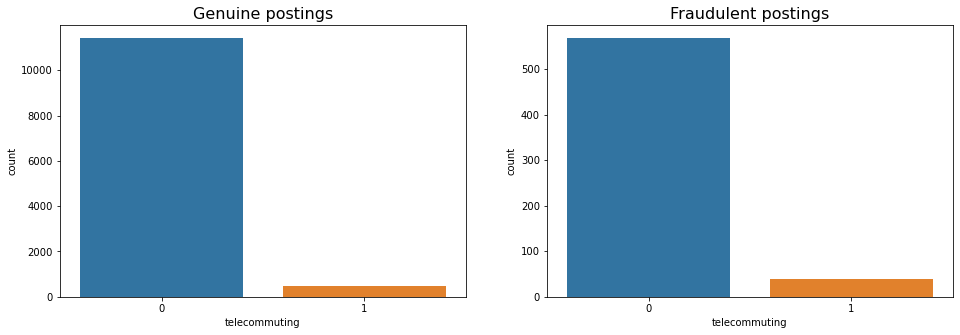

In [ ]:
plot_countplots('telecommuting')

#### Company logo

Whether a job posting has a company logo may be a useful predictive feature as most genuine jobs have a company logo, and most fraudulent job postings do not:

In [ ]:
train_npp['has_company_logo'].value_counts()

1    9921
0    2595
Name: has_company_logo, dtype: int64

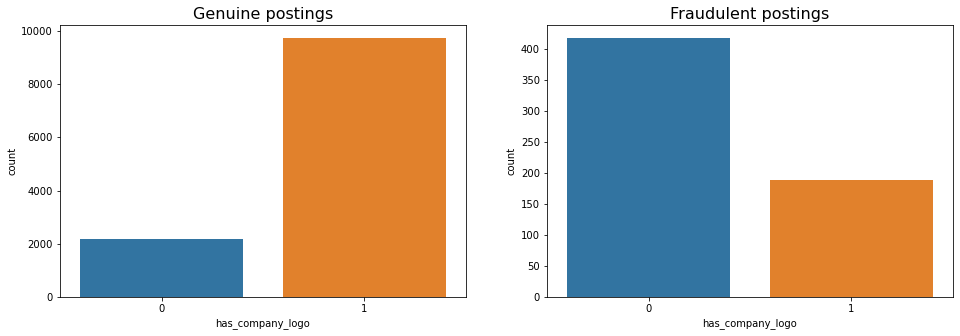

In [ ]:
plot_countplots('has_company_logo')

#### Questions

Potentially a useful predictive feature as there is a different distribution for genuine and fruadulent postings:

In [ ]:
train_npp['has_questions'].value_counts()

0    6364
1    6152
Name: has_questions, dtype: int64

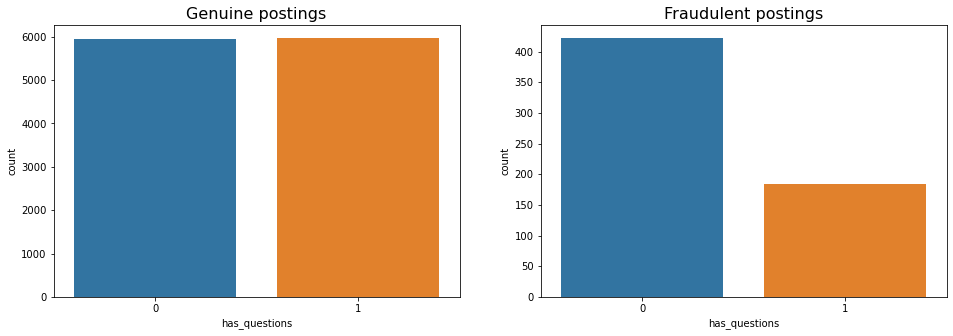

In [ ]:
plot_countplots('has_questions')

### Categorical variables

We can see from inspecting the categories that all the categorical features are nominal, not ordinal.

#### Employment type

There is no obvious difference in distribution between genuine and fraudulent postings - for both, the majority of jobs advertised are full-time:

In [ ]:
train_npp.value_counts('employment_type')

employment_type
Full-time    8152
Contract     1039
Part-time     546
Temporary     175
Other         155
dtype: int64

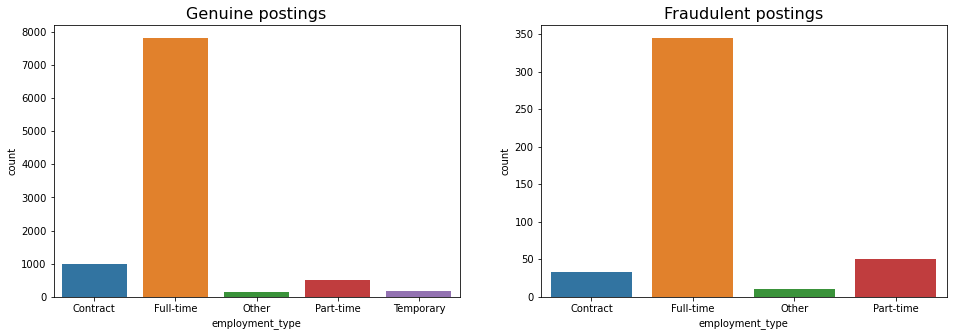

In [ ]:
plot_countplots('employment_type')

#### Required experience

We can see the distribution for required experience differs across genuine and fruadulent postings, especially for the 'Associate', 'Entry-level' and 'Mid-Senior Level' categories:

In [ ]:
train_npp.value_counts('required_experience')

required_experience
Mid-Senior level    2653
Entry level         1877
Associate           1599
Not Applicable       771
Director             284
Internship           267
Executive             99
dtype: int64

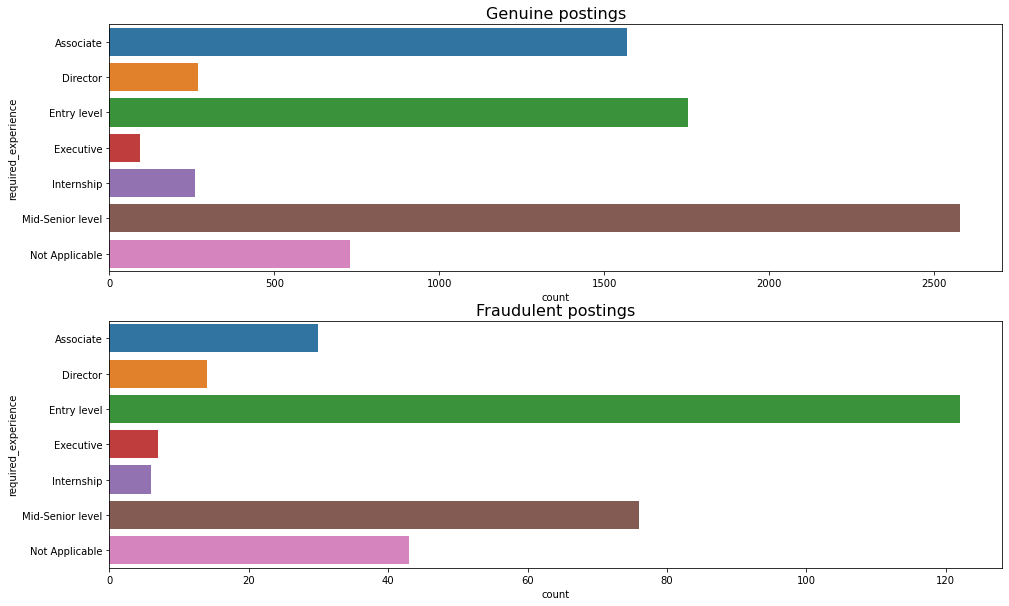

In [ ]:
plot_countplots_bar('required_experience')

#### Required education

We can see required education varied across genuine and fraudulent postings, with fraudulent postings more likely to require less educational experience - most jobs only ask for high school experience, compared to real jobs, which most commonly require a degree.

In [ ]:
train_npp.value_counts('required_education')

required_education
Bachelor's Degree                    3582
High School or equivalent            1459
Unspecified                           957
Master's Degree                       282
Associate Degree                      190
Certification                         111
Some College Coursework Completed      65
Professional                           50
Vocational                             32
Some High School Coursework            19
Doctorate                              17
Vocational - Degree                     5
Vocational - HS Diploma                 4
dtype: int64

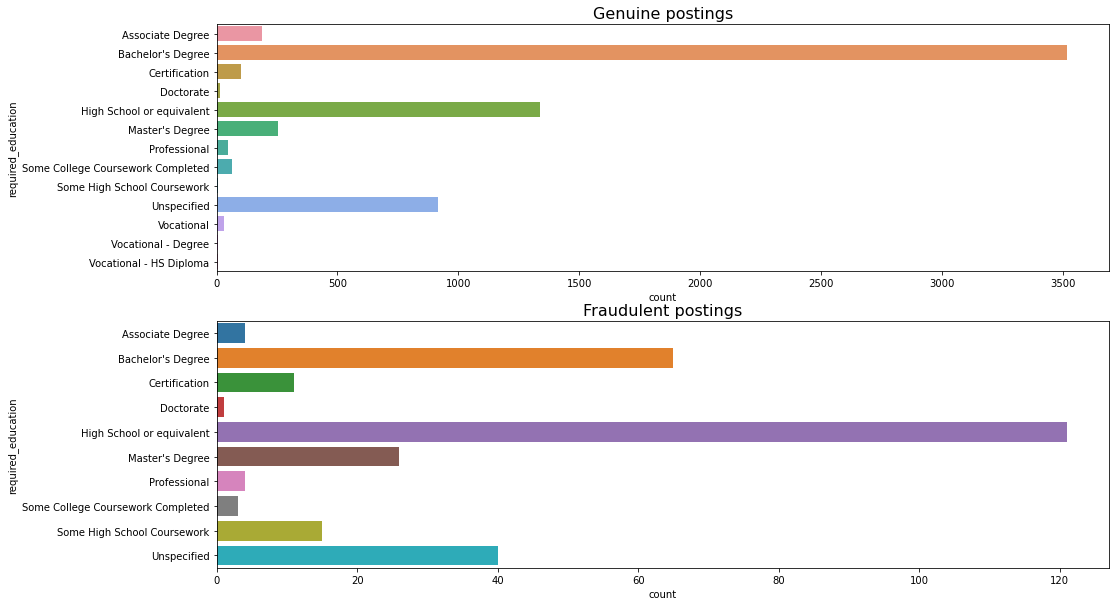

In [ ]:
plot_countplots_bar('required_education')

#### Industry

We can see the top industries for real and fraudulent vary, so this may be a predictive variable:

In [ ]:
train_npp.value_counts('industry').head()

industry
Information Technology and Services    1195
Computer Software                       943
Internet                                736
Marketing and Advertising               577
Education Management                    555
dtype: int64

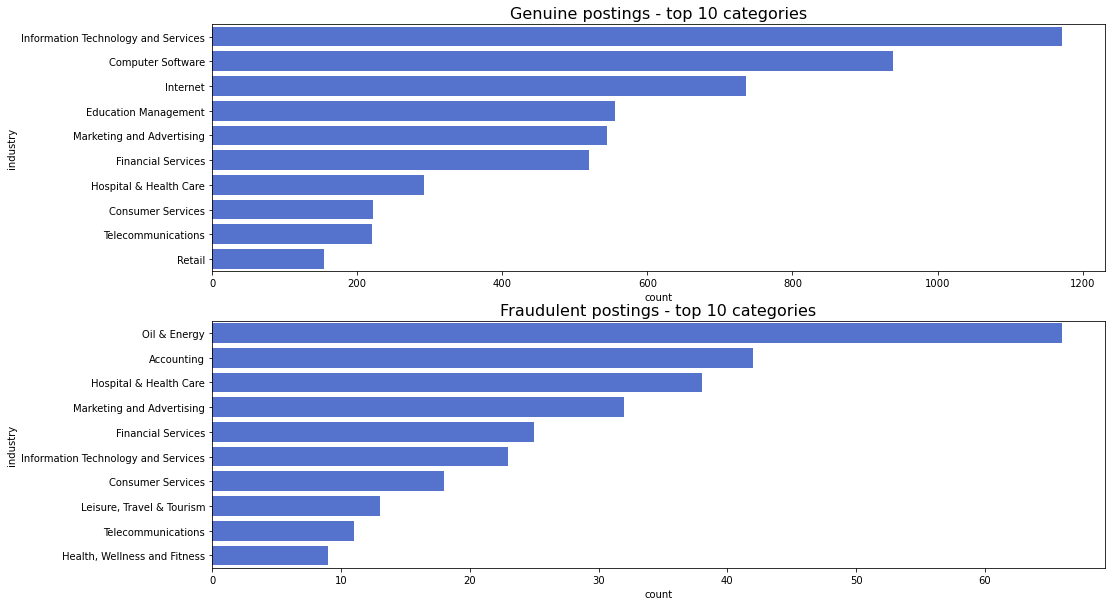

In [ ]:
plot_countplots_bar_lim('industry')

#### Function

We can see the top functions for real and fraudulent vary somewhat, so this may be a predictive variable:

In [ ]:
train_npp.value_counts('function').head()

function
Information Technology    1233
Sales                     1046
Engineering                941
Customer Service           855
Marketing                  564
dtype: int64

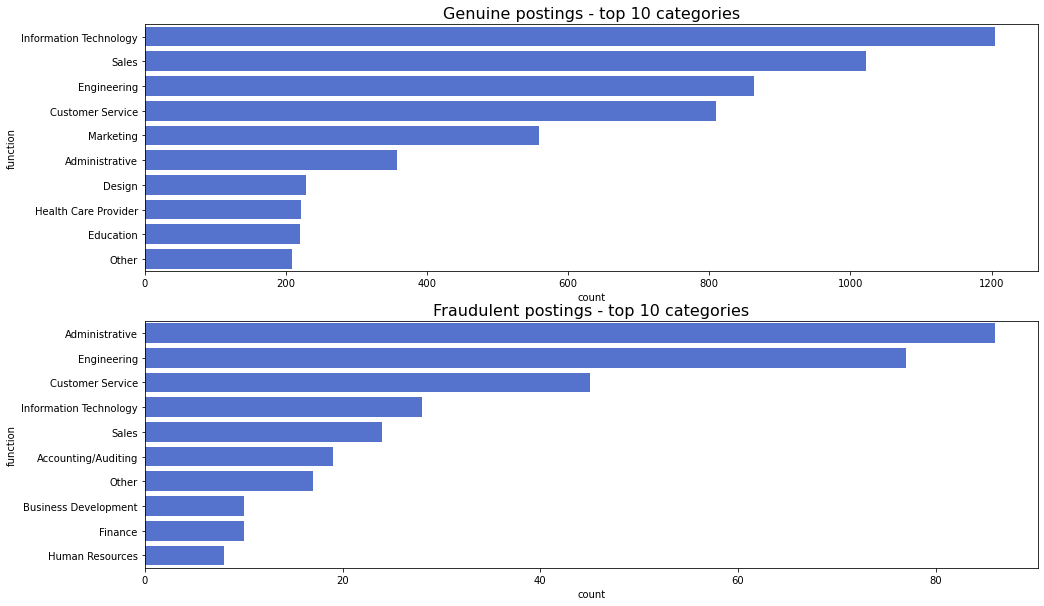

In [ ]:
plot_countplots_bar_lim('function')

### Structured

salary_range and location are technically strings, but have structure within them.

#### Salary range

Salary, when not missing, is structured as integer/dash/integer:

In [ ]:
train_npp['salary_range'].head()

0            NaN
1            NaN
2            NaN
3    45000-60000
4    32000-52000
Name: salary_range, dtype: object

Salary range is more commonly reported on in fraudulent job postings than genuine ones:

In [ ]:
100 - train_npp['salary_range'][train_npp['fraudulent']==0].isna().sum()/len(train_npp[train_npp['fraudulent']==0])*100

15.575146935348442

In [ ]:
100 - train_npp['salary_range'][train_npp['fraudulent']==1].isna().sum()/len(train_npp[train_npp['fraudulent']==1])*100

24.752475247524757

Given how large the proportion of job postings without salary data are, we will not use the salary_range data as a predictor beyond whether or not it present. 

#### Location

We can see the structure of the location feature, and it seems this information was collected by allowing posters to select locations from a list (or possibly free-write them) - each location is separated by a comma:

In [ ]:
train_npp['location'].head(20)

0              US, OH, Tiffin
1              DE, BE, Berlin
2             US, NC, Raleigh
3             GB, LND, London
4          US, WA, Bellingham
5              US, MA, Boston
6            US, NY, New York
7            US, NY, Brooklyn
8                     GR, I, 
9              BE, , Brussels
10         BE, , Valanciennes
11         US, MN, Minnetonka
12    US, CA, Manhattan Beach
13           US, OR, Portland
14                     US, , 
15              IN, RJ, Churu
16               US, NV, Reno
17         US, CA, Sacramento
18              GB, , Cheadle
19            US, , Newcastle
Name: location, dtype: object

We can look at some of the most common locations:

In [ ]:
jobs_locations = []

for i in train_npp.index:
    if type(train_npp['location'][i]) != float:
        locs = train_npp['location'][i].split(',')
        for l in locs:
            if len(l.strip()) > 0:
                jobs_locations.append(l.strip())
                
jobs_loc_counts = pd.DataFrame(columns = ['Location', 'Count'])

i = 0

for l in set(jobs_locations):
    jobs_loc_counts.loc[i, 'Location'] = l
    jobs_loc_counts.loc[i, 'Count'] = jobs_locations.count(l)
    i += 1

In [ ]:
def get_loc_counts(df):

    jobs_locations = []

    for i in df.index:
        if type(df['location'][i]) != float:
            locs = df['location'][i].split(',')
            for l in locs:
                if len(l.strip()) > 0:
                    jobs_locations.append(l.strip())

    jobs_loc_counts = pd.DataFrame(columns = ['Location', 'Count'])

    i = 0

    for l in set(jobs_locations):
        jobs_loc_counts.loc[i, 'Location'] = l
        jobs_loc_counts.loc[i, 'Count'] = jobs_locations.count(l)
        i += 1
        
    return jobs_loc_counts

In [ ]:
jobs_loc_count_gen = get_loc_counts(train_npp[train_npp['fraudulent'] == 0])

In [ ]:
jobs_loc_count_fr = get_loc_counts(train_npp[train_npp['fraudulent'] == 1])

In [ ]:
jobs_loc_count_gen.sort_values('Count', ascending=False).head(10)

,Location,Count
1480,US,6931
691,GB,1672
471,CA,1671
602,NY,829
443,London,770
1513,LND,705
1508,GR,680
1213,TX,587
1786,I,497
414,New York,455


In [ ]:
jobs_loc_count_fr.sort_values('Count', ascending=False).head(10)

,Location,Count
200,US,506
272,CA,115
55,TX,103
203,Houston,61
27,NY,50
149,AU,29
283,MD,25
174,NSW,23
81,Sydney,22
50,San Mateo,21


We see the most common locations between real and fraudulent postings vary a little, but not very significantly. This makes sense, as fraudulent posters likely target areas where many people live (and therefore where many real jobs are avaliable). 

We can see that a substancial number of locations only appear once:

In [ ]:
len(jobs_loc_counts)

2251

In [ ]:
len(jobs_loc_counts[jobs_loc_counts['Count'] == 1])

1059

# Pre-processing

## Binary & categorical variables

The binary variables do not need any further processing. Categorical variables are all nominal, and so should be one-hot encoded.

In [ ]:
bin_vars = ['telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']
cat_vars = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']

train_bin = train_npp[bin_vars]

train_cat = train_npp[cat_vars]

In [ ]:
def onehotcats(df):
    oh_encoder = OneHotEncoder()
    
    df_ohencoded = df.copy()
    
    for col in cat_vars:
        oh = oh_encoder.fit_transform(df[[col]])
        oh_df = pd.DataFrame(columns=oh_encoder.get_feature_names_out(), data=oh.toarray())
        df_ohencoded = df_ohencoded.join(oh_df)
        
    return df_ohencoded.drop(cat_vars, axis=1)

In [ ]:
train_cat_oh = onehotcats(train_cat)

In [ ]:
train_cat_oh.head()

,employment_type_Contract,employment_type_Full-time,employment_type_Other,employment_type_Part-time,employment_type_Temporary,employment_type_nan,required_experience_Associate,required_experience_Director,required_experience_Entry level,required_experience_Executive,...,function_Purchasing,function_Quality Assurance,function_Research,function_Sales,function_Science,function_Strategy/Planning,function_Supply Chain,function_Training,function_Writing/Editing,function_nan
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Salary range

As previously established, we will not use the salary_range data itself as most job postings did not include this information, however, salary_range was more commonly present for fruadulent postings, so we can make a binary variable indicating whether salary_range was included or not for each posting:

In [ ]:
train_sr = train_npp[['salary_range']]

train_sr['sr_exists'] = [int(type(sr) != float) for sr in train_sr['salary_range']]

<ipython-input-135-33ce79d19bc1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_sr['sr_exists'] = [int(type(sr) != float) for sr in train_sr['salary_range']]


In [ ]:
train_sr.head()

,salary_range,sr_exists
0,NaN,0
1,NaN,0
2,NaN,0
3,45000-60000,1
4,32000-52000,1


### Join binary, categorical and salary indicator features into one dataframe

We will use this for feature selection.

In [ ]:
train_bcs = train_bin.join(train_cat_oh).join(train_sr[['sr_exists']])

In [ ]:
train_bcs.head()

,telecommuting,has_company_logo,has_questions,fraudulent,employment_type_Contract,employment_type_Full-time,employment_type_Other,employment_type_Part-time,employment_type_Temporary,employment_type_nan,...,function_Quality Assurance,function_Research,function_Sales,function_Science,function_Strategy/Planning,function_Supply Chain,function_Training,function_Writing/Editing,function_nan,sr_exists
0,0,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,0,1,1,0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0,1,1,0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,0,1,1,0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0,1,1,0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1


## Location

Getting locations to make features out of - these will also be subject to feature selection at a later stage. We only include locations which have 10 or more occurences in the training data, otherwise we will have a very large number of locations which only occur a few times, which both unnecessarily adds to the dimensionality, as well as could cause overfitting if used for training (most locations will not be seen in the fraudulent data, whereas those locations seen in the fraudulent data will be marked as substancially more likely to be fraudulent, even if the location only existed in one or two fraudulent postings and is not a general trend which can be useful for predicting unseen data).

In [ ]:
jobs_locations = []

for i in train_npp.index:
    if type(train_npp['location'][i]) != float:
        locs = train_npp['location'][i].split(',')
        for l in locs:
            if len(l.strip()) > 0:
                jobs_locations.append(l.strip())
                
jobs_loc_counts = pd.DataFrame(columns = ['Location', 'Count'])

i = 0

for l in set(jobs_locations):
    jobs_loc_counts.loc[i, 'Location'] = l
    jobs_loc_counts.loc[i, 'Count'] = jobs_locations.count(l)
    i += 1
    
# Only want locations with more than 10 occurances, otherwise will have a very high number of rare locations
location_fts = [jobs_loc_counts['Location'][i] for i in jobs_loc_counts.index if jobs_loc_counts['Count'][i] > 9]

In [ ]:
len(location_fts)

311

In [ ]:
def onehotloc(df):
    df_loc = df[['location']]
    
    # Add locations as columns, give an initial value of 0 to all
    for loc in location_fts:
        df_loc.insert(len(df_loc.columns), column = loc, value = [0 for i in df_loc.index])
    
    for i in df_loc.index:
        if type(df_loc['location'][i]) == str: 
            locs_all = df_loc['location'][i]

            # Get only locations being used as features
            locs = [l.strip() for l in locs_all.split(',') if l.strip() in location_fts] 

            # One-hot encode locations
            for loc in locs:
                df_loc.loc[i, loc] = 1
            
    return df_loc.drop('location', axis=1)

In [ ]:
train_locs = onehotloc(train_npp)

C:\Users\Masters\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
train_locs.head()

,DU,PH,Tel Aviv,Columbus,LND,El Segundo,Nashville,37,Birmingham,Miami,...,Salt Lake City,QLD,Stockholm,London,Houston,FI,NYK,Jersey City,PT,Chamberi | Madrid
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Text data

Before we convert text to vectors, some text cleaning can be beneficial. Let's tokenise the strings of the description feature to have a look at some of the tokens and identify some issues we may want to clean up:

In [ ]:
all_desc = []
all_title = []

for i in jobs.index:
    if type(jobs['description'][i]) != float:
        desc = jobs['description'][i].lower().split()
    title = jobs['title'][i].lower().split()
    
    for w in desc:
        all_desc.append(w.strip())
        
    for w in title:
        all_title.append(w.strip())

In [ ]:
set(all_desc)

{'obiee.',
 'operations.experience',
 'world.vmob',
 'domains.',
 'seedhack',
 'lineother',
 'lorries',
 '2012.design',
 'lever).we',
 'fl.all',
 'commisssions.',
 'διοικητικής',
 'marvelous',
 'staffproduce',
 'beaufort3557',
 'difference’',
 'writing.within',
 'accuracysource',
 'summaryinitiates',
 'suppliescoordinate',
 'mu',
 'thailand.responsible',
 '(#url_719340aef4872adc9cafd8b369168c5a0fce6645fb5a8149fb38b31ed893afc2#)rachel',
 'parents•',
 'suites153',
 'monthsrate',
 'members)',
 'requested.you’ll',
 'firm',
 'properly.sleuthing',
 'will:plan',
 'teamwork.self-motivated.',
 'repurchase',
 '(gd&amp;t)-makes',
 'writinga',
 'for.reporting',
 'millions.responsibilitiesdesign,',
 'equipment.able',
 '-enter',
 'basis.adheres',
 'longer)',
 'usd,',
 'skirting',
 'eye',
 'items.staying',
 'clients)',
 'with:tertiary',
 'smaller,',
 'employed.',
 'summaries,',
 'last',
 'revenue.',
 'life!####',
 'schedule.develops',
 'stuff!please',
 'underperformancewe',
 'nation-wide.stock/invent

Number of unique tokens:

In [ ]:
len(set(all_desc))

138884

Number of unique tokens with a full-stop (not on the end of the token as per the end of a sentence): 

In [ ]:
len(set([s for s in all_desc if s[:-1].__contains__('.')]))

28884

Some of the issues within the text we want to clean:
* We have URLS, which are formatted '#url_.......#' - each one will be unique. However, the existence of URLs may be useful information, so we can replace them with 'url_'. We can do the same for email tags, '#email.....#', and other similar sets.
* Often, there are spaces missing after full stops, for example 'judgment.demonstrating'. This is very common in text which has been scraped online, as often new line characters are removed to make the text into a single string, and authors rarely put a space on the end of a sentence at the end of the paragraph before starting a new one. We see that over 20% of all unique tokens extracted from descriptions have a full stop in the middle of the token (not on the end) - this text quality issue is very prevalent so we should take the time to clean it. We can also include other punctuation used to end sentences (! and ?).

We can see that we still have a huge amount of unique tokens. We can reduce dimensionality further by: 
* Removing stop words (common words which do not reveal a topic or much information, such as 'and' and 'the').
* We can stem or lemmatise words. Lemmatisation is preferable as it converts a word to it's base form which will preserve the true meaning of the word, whereas stemming removes common prefixes and suffixes, which can be problematic for context. For example the lemma of the word 'baring' is 'bare', but the stem is 'bar', and we can clearly see bare and bar usually have very different meaning and context.
* We can ignore tokens which only occur once or very rarely, as it is overwhelmingly likely they will never occur again and have no predictive power.

Now we can write a data cleaning function:

In [ ]:
# Load spaCy core language model
spacy_model = spacy.load('en_core_web_sm')

# Get spaCy stopwords
stopwords = spacy_model.Defaults.stop_words

# Input is the dataframe, columns to clean and whether to remove tokens which only occur in one row
def clean_text(df, cols, remove_single=False):
    
    # Clean each column in the list specified
    for col in cols:
        
        # List to track all tokens
        all_tokens = []

        for i in df.index:

            txt = df[col][i]

            # If not null
            if txt == txt:
                # Deal with sentence endings which may not have necessary spaces after them
                txt = re.sub('!|\.|\?', ' ', txt.lower())

                # Remove remaining punctuation by removing all characters which are not alphanumeric, whitespace or understores    
                txt = re.sub(r'[^\w\s]', '', txt)

                # Create a spaCy object (required for lemmatisation)
                sp_txt = spacy_model(txt)

                # Tokenise string and lemmatise words
                tokens = [t.lemma_ for t in sp_txt]

                # Remove stop words
                tokens = [t for t in tokens if t not in stopwords]

                # Deal with URLs and links by getting rid of any numbers and values after underscores
                # Keep underscore to differentiate links from the word 'URL'
                tokens_underscore = [t.split('_')[0]+'_' for t in tokens if t.__contains__('_')]
                tokens_other = [t for t in tokens if not t.__contains__('_')]
                tokens = tokens_underscore + tokens_other
                
                # Remove other url markers and single underscore tokens
                tokens = [t for t in tokens if t!='_' and not t.__contains__('http90url')]

                # Append to all tokens list
                all_tokens += set(tokens)

                # Store
                df.loc[i, col] = ' '. join(tokens)

        if remove_single == True:
            # Procedure to remove all tokens that only appear in one row to reduce dimensionality
            tokens_keep = [t for t in set(all_tokens) if all_tokens.count(t) > 1]

            for i in df.index:

                txt = df[col][i]

                if txt==txt:
                    tokens = txt.split()

                    # Include only tokens which appear at least twice
                    tokens = [t for t in tokens if t in tokens_keep]

                    # Join tokens back into a string ready for tf-idf vectorisation
                    df.loc[i, col] = ' '.join(tokens)

    # Return dataframe with cleaned text
    return df

Get text columns:

In [ ]:
text_cols = ['title', 'company_profile', 'description', 'requirements', 'benefits']

train_text = train_npp[text_cols]

In [ ]:
train_text_clean = clean_text(train_text.copy(), text_cols)

In [ ]:
# Save as processing takes a long time
train_text_clean.to_csv('train_text_clean.csv')

In [4]:
train_text_clean = pd.read_csv('train_text_clean.csv', index_col=0)

train_text_clean.head()

,title,company_profile,description,requirements,benefits
0,english teacher abroad,help teacher safe amp secure job abroad,url_ play kid pay love travel job asia1500...,university degree require tefl tesol cel...,job description
1,sale manager,NaN,url_ contentful apifirst content management pl...,successful history selling software ideally sa...,web change interactive revolution work cutting...
2,title sale representative,email_ phone_ phone_ network closing service ...,sanchezphone_ network closing services inc s...,experienced candiate onlya successful candid...,provide fun rewarding atmosphere employee supp...
3,php lamp magento symfony zend developer,wedo collection niched ecommerce store aim des...,referral bonus offer 500 successful placemen...,qualificationsstrong commercial programming ex...,benefit product discount great environment...
4,inside sale specialist western region,posx rapidly grow pointofsale hardware manufac...,url_ posx rapidly grow pointofsale hardware ma...,qualificationsstrong interest sale customer se...,pay 32 52k depend experience performanceheal...


We can now see the difference between the original and cleaned text:

In [ ]:
train_text.head()

,title,company_profile,description,requirements,benefits
0,English Teacher Abroad,We help teachers get safe &amp; secure jobs ab...,"Play with kids, get paid for it Love travel? J...",University degree required. TEFL / TESOL / CEL...,See job description
1,Sales Manager,NaN,Contentful (#URL_0252efddcbc4b8f51969fca7b0545...,Successful history selling software (ideally S...,The Web is changing and becoming more interact...
2,Title Sales Representative,Network Closing Services has been serving Lend...,"Network Closing Services, Inc., a full service...",**Experienced candiates only**A successful ca...,"We provide a fun and rewarding atmosphere, our..."
3,PHP / LAMP / Magento / Symfony / Zend Developer,Wedo is a collection of niched e-commerce stor...,** Referral Bonus **We're offering £500 for a ...,Qualifications:Strong commercial programming e...,Benefits: • Product discounts • A great enviro...
4,Inside Sales Specialist Western Region,POS-X is a rapidly growing point-of-sale hardw...,POS-X is a rapidly growing point-of-sale hardw...,QualificationsStrong interest in a sales and c...,"Pay $32 - $52k, Depending on experience and pe..."


In [ ]:
train_text_clean.head()

,title,company_profile,description,requirements,benefits
0,english teacher abroad,help teacher safe amp secure job abroad,url_ play kid pay love travel job asia1500...,university degree require tefl tesol cel...,job description
1,sale manager,NaN,url_ contentful apifirst content management pl...,successful history selling software ideally sa...,web change interactive revolution work cutting...
2,title sale representative,email_ phone_ phone_ network closing service ...,sanchezphone_ network closing services inc s...,experienced candiate onlya successful candid...,provide fun rewarding atmosphere employee supp...
3,php lamp magento symfony zend developer,wedo collection niched ecommerce store aim des...,referral bonus offer 500 successful placemen...,qualificationsstrong commercial programming ex...,benefit product discount great environment...
4,inside sale specialist western region,posx rapidly grow pointofsale hardware manufac...,url_ posx rapidly grow pointofsale hardware ma...,qualificationsstrong interest sale customer se...,pay 32 52k depend experience performanceheal...


We can also explore the relative size of each text feature:

In [ ]:
for col in train_text_clean:
    all_words = []
    for i in train_text_clean.index:
        all_words += str(train_text_clean[col][i]).split()
    print('For', col, '\nTotal words:', len(all_words), '\nUnique words:', len(set(all_words)), '\n')

For title 
Total words: 42172 
Unique words: 4201 

For company_profile 
Total words: 670279 
Unique words: 13023 

For description 
Total words: 1306355 
Unique words: 56661 

For requirements 
Total words: 649606 
Unique words: 45602 

For benefits 
Total words: 235306 
Unique words: 14382 



### TF-IDF vectorisation

While we will use word embeddings for neural networks, we will use the simpler Bag of Words representation of text for other models. However we can use a more advanced version of the Bag of Words model than a simple count vectoriser, and use TF-IDF vectorisation.

To reduce dimensionsionality, we will combine the text of each job posting together and vectorise the single block of text.

In [5]:
train_text_clean['all_text'] = ''

for i in train_text_clean.index:
    txt = ''
    for c in ['title', 'company_profile', 'description', 'requirements', 'benefits']:
        txt += ' ' + str(train_text_clean[c][i])
    train_text_clean.loc[i, 'all_text'] = txt
    
train_text_clean.head()

,title,company_profile,description,requirements,benefits,all_text
0,english teacher abroad,help teacher safe amp secure job abroad,url_ play kid pay love travel job asia1500...,university degree require tefl tesol cel...,job description,english teacher abroad help teacher safe amp ...
1,sale manager,NaN,url_ contentful apifirst content management pl...,successful history selling software ideally sa...,web change interactive revolution work cutting...,sale manager nan url_ contentful apifirst con...
2,title sale representative,email_ phone_ phone_ network closing service ...,sanchezphone_ network closing services inc s...,experienced candiate onlya successful candid...,provide fun rewarding atmosphere employee supp...,title sale representative email_ phone_ phone...
3,php lamp magento symfony zend developer,wedo collection niched ecommerce store aim des...,referral bonus offer 500 successful placemen...,qualificationsstrong commercial programming ex...,benefit product discount great environment...,php lamp magento symfony zend develop...
4,inside sale specialist western region,posx rapidly grow pointofsale hardware manufac...,url_ posx rapidly grow pointofsale hardware ma...,qualificationsstrong interest sale customer se...,pay 32 52k depend experience performanceheal...,inside sale specialist western region posx ra...


In [6]:
# Will only consider the 1000 most frequent terms
vectorizer = TfidfVectorizer(max_features=1000)
train_text_tfidf = vectorizer.fit_transform(train_text_clean['all_text'])

In [7]:
train_tfidf= pd.DataFrame(columns=vectorizer.get_feature_names_out(), data=train_text_tfidf.toarray())

train_tfidf.head()

,10,100,12,1500,20,200,2014,30,40,401k,...,workplace,world,worldclass,worldwide,write,writing,year,york,young,και
0,0.0,0.0,0.0,0.0,0.0,0.186433,0.0,0.0,0.000000,0.0,...,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.08013,0.043195,0.0,0.0,0.041034,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.00000,0.000000,0.0,0.0,0.038359,0.0,0.027109,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.078354,0.0,...,0.00000,0.000000,0.0,0.0,0.038588,0.0,0.027271,0.0,0.0,0.0


## Test data 

Clean the test text data also:

In [ ]:
test_text = test_npp[text_cols]

In [ ]:
test_text_clean = clean_text(test_text.copy(), text_cols)

In [ ]:
# Save as processing takes a long time
test_text_clean.to_csv('test_text_clean.csv')

In [8]:
test_text_clean = pd.read_csv('test_text_clean.csv', index_col=0)

test_text_clean.head()

,title,company_profile,description,requirements,benefits
0,inside sale development rep,curvo lab exciting fund startup determined cha...,curvo lab exciting early stage fund startup de...,experienceurl_ requirementsa great desire lear...,employee benefit ability participate stock opt...
1,end developer,squiz world lead web solution company design...,live breathe frontend development passionate...,NaN,NaN
2,production qa technician time,30 year experience industry mercer food provid...,job title quality assurance technician timed...,primary duty responsibilities1 confirm plant...,NaN
3,account director,evh fashion lifestyle design luxury communicat...,australia fast grow fashion luxury lifestyle a...,excellent write communication presentation ski...,NaN
4,optician union square,magnify life progressive inspire honest de...,jin optician nt glass create extraordinary e...,licensing certificationvalid work permit unite...,NaN


In [9]:
test_text_clean['all_text'] = ''

for i in test_text_clean.index:
    txt = ''
    for c in ['title', 'company_profile', 'description', 'requirements', 'benefits']:
        txt += ' ' + str(test_text_clean[c][i])
    test_text_clean.loc[i, 'all_text'] = txt

In [10]:
test_text_tfidf = vectorizer.transform(test_text_clean['all_text'])
test_tfidf= pd.DataFrame(columns=vectorizer.get_feature_names_out(), data=test_text_tfidf.toarray())

# Feature selection / dimension reduction

## Correlation

### Binary and categorical

In [ ]:
len(train_bcs.columns)

203

In [ ]:
corr_bcs = train_bcs.corr()

Features most correlated with the target variable, which we notice align with some of the trends we saw earlier during data exportation:

In [ ]:
corr_bcs[['fraudulent']].abs().sort_values('fraudulent', ascending=False).head(15)

,fraudulent
fraudulent,1.000000
has_company_logo,0.268434
industry_Oil & Energy,0.176570
industry_Accounting,0.140544
required_education_Some High School Coursework,0.134616
function_Administrative,0.129798
required_education_Bachelor's Degree,0.089300
has_questions,0.084781
"industry_Leisure, Travel & Tourism",0.065265
industry_Computer Software,0.058748


Features with an absolute correlation of over 0.5 with each other:

In [ ]:
high_corrs = pd.DataFrame(columns=['Feat A', 'Feat B', 'Correlation'])
complete_feats = []

# Only predictive features
corr_bcs_feat = corr_bcs.drop('fraudulent', axis=1)

for i in corr_bcs_feat.index:
    for c in corr_bcs_feat.columns:
        if i!=c and (c not in complete_feats):
            if abs(corr_bcs_feat[c][i]) > 0.5:
                high_corrs = high_corrs.append({'Feat A': i, 'Feat B':c, 'Correlation': corr_bcs_feat[c][i]}, 
                                               ignore_index=True)
            
    complete_feats.append(i)

In [ ]:
high_corrs.sort_values('Correlation', ascending=False)

,Feat A,Feat B,Correlation
3,employment_type_nan,industry_nan,0.702473
7,required_experience_nan,function_nan,0.638434
0,employment_type_Contract,industry_Education Management,0.625896
6,required_experience_nan,industry_nan,0.602012
5,required_experience_nan,required_education_nan,0.597580
12,industry_Public Relations and Communications,function_Public Relations,0.585700
13,industry_nan,function_nan,0.579305
10,required_education_nan,function_nan,0.550060
11,industry_Fishery,function_Science,0.547569
2,employment_type_nan,required_experience_nan,0.543112


We see that mostly high correlation exists with missing data, but no correlations are so high that we can remove fields on the basis of high correlation.

### Location

In [ ]:
train_locs_fr = train_locs.join(train_npp[['fraudulent']])

train_locs_fr.head()

,DU,PH,Tel Aviv,Columbus,LND,El Segundo,Nashville,37,Birmingham,Miami,...,QLD,Stockholm,London,Houston,FI,NYK,Jersey City,PT,Chamberi | Madrid,fraudulent
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
corr_locs = train_locs_fr.corr()

In [ ]:
corr_locs[['fraudulent']].abs().sort_values('fraudulent', ascending=False).head(15)

,fraudulent
fraudulent,1.000000
Bakersfield,0.172860
Houston,0.156592
AUSTIN,0.148352
San Mateo,0.129630
Sydney,0.114119
TX,0.113498
US,0.110641
MD,0.103060
NSW,0.093415


Features with an absolute correlation of over 0.9 with each other:

In [ ]:
high_corrs_locs = pd.DataFrame(columns=['Loc A', 'Loc B', 'Correlation'])
complete_locs = []

# Only predictive features
corr_locs_only = corr_locs.drop('fraudulent', axis=1)

for i in corr_locs_only.index:
    for c in corr_locs_only.columns:
        if i!=c and (c not in complete_locs):
            if abs(corr_locs_only[c][i]) > 0.9:
                high_corrs_locs = high_corrs_locs.append({'Loc A': i, 'Loc B':c, 'Correlation': corr_locs_only[c][i]}, 
                                               ignore_index=True)
            
    complete_locs.append(i)

In [ ]:
high_corrs_locs.sort_values('Correlation', ascending=False)

,Loc A,Loc B,Correlation
8,Valencia,VC,1.000000
6,EE,Tallinn,0.956497
7,Washington,DC,0.954637
0,37,EE,0.938542
3,J,Paris,0.927434
2,Montreal,QC,0.921844
4,Melbourne,VIC,0.920032
5,NZ,N,0.914282
1,37,Tallinn,0.905422


We have some highly correlated location features. Where two locations are highly correlated, we will drop the one which appears least in the data:

In [ ]:
# Drop one location between highly correlated variables - drop the one which appears least in the data
drop_locs = []

for i in high_corrs_locs.index:
    locA = high_corrs_locs['Loc A'][i]
    locB = high_corrs_locs['Loc B'][i]
    locA_count = train_locs[locA].sum()
    locB_count = train_locs[locB].sum()
    if locA_count <= locB_count:
        drop_locs.append(locA)
    else:
        drop_locs.append(locB)

In [ ]:
# Reduced dimension
train_locs_rd = train_locs.drop(drop_locs, axis = 1)

## Chi-squared

### Binary and categorical

We calculate the chi-squared statistic and p-values. We will keep variables which have a p-value of 0.05 or less, corresponding to a 95% confidence that the variable is correlated with the target.

In [ ]:
bcs_chi2, bcs_pvals = chi2(train_bcs.drop('fraudulent', axis=1), train_bcs[['fraudulent']])

In [ ]:
c = 0
sig_chi2_bcs = []
notsig_chi2_bcs = []

for i in bcs_pvals:
    if i <= 0.05:
        sig_chi2_bcs.append(train_bcs.drop('fraudulent', axis=1).columns[c])
    else:
        notsig_chi2_bcs.append(train_bcs.drop('fraudulent', axis=1).columns[c])
    c += 1

We can see we can reduce the dimensions of the binary and categorical variables by about a quarter:

In [ ]:
len(sig_chi2_bcs)

52

In [ ]:
len(notsig_chi2_bcs)

150

In [ ]:
# Reduced dimension dataframe
train_bcs_rd = train_bcs.drop(notsig_chi2_bcs, axis=1)

### Location

As with binary and categorical values, keep only features with a chi-squared p-value of 0.05 or less:

In [ ]:
locs_chi2, locs_pvals = chi2(train_locs_rd, train_locs_fr[['fraudulent']])

In [ ]:
c = 0
sig_chi2_locs = []
notsig_chi2_locs = []

for i in locs_pvals:
    if i <= 0.05:
        sig_chi2_locs.append(train_locs_rd.columns[c])
    else:
        notsig_chi2_locs.append(train_locs_rd.columns[c])
    c += 1

In [ ]:
len(sig_chi2_locs)

48

In [ ]:
len(notsig_chi2_locs)

255

In [ ]:
# Reduced dimension
train_locs_rd = train_locs_rd.drop(notsig_chi2_locs, axis = 1)

## Combine processed data

For neural networks, text and non-text data will be separate inputs. We prepare a dataframe with non-text data:

In [ ]:
train_nt = train_bcs_rd.join(train_locs_rd)

## Process non-text test data 

In [ ]:
# Process binary, categorical data
test_bin = test_npp[bin_vars]
test_cat = test_npp[cat_vars]
test_cat_oh = onehotcats(test_cat)
test_sr = test_npp[['salary_range']]
test_sr['sr_exists'] = [int(type(sr) != float) for sr in test_sr['salary_range']]
test_bcs = test_bin.join(test_cat_oh).join(test_sr[['sr_exists']])

# Drop non-significant features
test_bcs_rd = test_bcs.drop([c for c in notsig_chi2_bcs if c in test_bcs.columns], axis=1)

# Process location data and drop non-significant features
test_locs = onehotloc(test_npp)
locs_drop_test = [c for c in drop_locs if c in test_locs.columns] + [c for c in notsig_chi2_locs if c in test_locs.columns]
test_locs_rd = test_locs.drop(locs_drop_test, axis = 1)

# Combine into one dataset
test_nt = test_bcs_rd.join(test_locs_rd)

# Drop any columns not in the train dataset
not_in_train = [c for c in test_nt.columns if c not in train_nt.columns]
if len(not_in_train) > 1:
    test_nt = test_nt.drop(not_in_train, axis=1)
    
# Add any columns in train not yet in test - data not seen in test but need the same number of columns
not_in_test = [c for c in train_nt.columns if c not in test_nt.columns]
# If float type, all values 0.0, if int type, all values 0
for c in not_in_test:
    if train_nt[c].dtype == float:
        test_nt[c] = 0.0
    else:
        test_nt[c] = 0
        
# Finally, we want to ensure the test and train dataframe columns are in the same order
test_nt = test_nt.reindex(columns=train_nt.columns)

<ipython-input-169-cd880ae08a3b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sr['sr_exists'] = [int(type(sr) != float) for sr in test_sr['salary_range']]
C:\Users\Masters\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Now we see the test and train non-text datasets have the same columns:

In [ ]:
train_nt.shape

(12516, 101)

In [ ]:
test_nt.shape

(5364, 101)

In [ ]:
test_nt.columns == train_nt.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [34]:
# Save progess
train_nt.to_csv('train_nt.csv')
test_nt.to_csv('test_nt.csv')

In [11]:
# Reload
train_nt = pd.read_csv('train_nt.csv', index_col=0)
test_nt = pd.read_csv('test_nt.csv', index_col=0)

train_nt.head()

,telecommuting,has_company_logo,has_questions,fraudulent,employment_type_Contract,employment_type_Full-time,employment_type_Part-time,employment_type_Temporary,employment_type_nan,required_experience_Associate,...,DE,AUSTIN,Brooklyn,Sydney,Omaha,I,NZ,NSW,San Francisco,GA
0,0,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0.0,1.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,1,0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,0.0,1.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0


# Word embeddings

## Bigram detection

We will use genism's Phrases to extract bigrams for text samples. We need to prepare a 'list of lists' to feed into Phrases. The first level of list is the samples, and the second level of list tokenised words for each sample. Phases will return both unigrams and bigrams, and we can get a genism 'list of lists' with both unigrams and unigrams for each sample to use as input into the models. To make sure we get the same bigrams for train and test, we will train Phrases on the text data, and then process both the train and text data with the Phases model immediately after. We also extract a genism Transformed corpus object which we will feed into word2vec to generate word embedding vectors.

In [ ]:
def get_bigrams(df_train, df_test, col, mc, thresh):
    train_data = [str(df_train[col][i]).split() for i in df_train.index]
    test_data = [str(df_test[col][i]).split() for i in df_test.index]
    
    # Higher threshold = fewer phrases
    bigrams = Phrases(train_data, min_count=mc, threshold=thresh)
    
    # Create dataset with bigrams - train
    bigrams_lst_train = [bigrams[train_data[i]] for i in range(len(train_data))]
    # Create dataset with bigrams - test
    bigrams_lst_test = [bigrams[test_data[i]] for i in range(len(test_data))]
    
    # genism Transformed corpus object to feed into word2vec
    tc = bigrams[train_data]
    
    return (bigrams_lst_train), (bigrams_lst_test), tc

The bigram min_count and threshold, and the word2vec vector size should vary by number of unique words for each text feature, which we can see below:

In [ ]:
for col in train_text_clean:
    all_words = []
    for i in train_text_clean.index:
        all_words += str(train_text_clean[col][i]).split()
    print(col, 'Unique words:', len(set(all_words)))

title Unique words: 4201
company_profile Unique words: 13023
description Unique words: 56661
requirements Unique words: 45602
benefits Unique words: 14382


Now we have a list of lists for both the train and test data, as well as a transformed corpus object for each text feature:

In [ ]:
train_desc_bgs, test_desc_bgs, desc_tc = get_bigrams(train_text_clean, test_text_clean, 'description', 
                                                     mc = 5, thresh = 1000)

In [ ]:
train_title_bgs, test_title_bgs, title_tc = get_bigrams(train_text_clean, test_text_clean, 'title', 
                                                        mc = 2, thresh = 100)

In [ ]:
train_cp_bgs, test_cp_bgs, cp_tc = get_bigrams(train_text_clean, test_text_clean, 'company_profile', 
                                               mc = 3, thresh = 3000)

In [ ]:
train_reqs_bgs, test_reqs_bgs, reqs_tc = get_bigrams(train_text_clean, test_text_clean, 'requirements', 
                                                     mc = 5, thresh = 1000)

In [ ]:
train_benefits_bgs, test_benefits_bgs, benefits_tc = get_bigrams(train_text_clean, test_text_clean, 
                                                                  'benefits', mc = 3, thresh = 300)

## Converting text to integer sequences

The format of text input into an embedding layer should be a sequence of integers. We will train the tokeniser on the training data and convert both the train and test data into a sequence of integers - any tokens in the test data not seen in the training data will be excluded in the integer sequences. The function below gets integer sequences of the train and test data, as well as the tokeniser word index (the map between the integer and the word) which we will need for creating the embedding layers of our neural networks later.

In [ ]:
def getIntSequences(train_data, test_data):
    # Test and train data will be in list of lists format from bigram extraction
    # Will need to be converted back to a single list of strings for each
    train_lst = []
    test_lst = []
    max_len = 0
    
    for i in train_data:
        train_lst.append(' '.join(i))
        if len(i) > max_len:
            max_len = len(i)
        
    for i in test_data:
        test_lst.append(' '.join(i))
    
    # Keras tokeniser
    tokenizer = Tokenizer()
    
    # Fit to training data
    tokenizer.fit_on_texts(train_lst)
    
    # Get integer sequences
    train_seqs = tokenizer.texts_to_sequences(train_lst)
    test_seqs = tokenizer.texts_to_sequences(test_lst)
    
    # Finally, we need to pad the sequences so they are all the same length - the max length seen in the training data
    train_seqs_pad = pad_sequences(train_seqs, maxlen=max_len)
    test_seqs_pad = pad_sequences(test_seqs, maxlen=max_len)
    
    # Get word index
    wi = tokenizer.word_index
    
    return (train_seqs_pad), (test_seqs_pad), wi

In [ ]:
train_desc_is, test_desc_is, desc_wi = getIntSequences(train_desc_bgs, test_desc_bgs)

In [ ]:
train_title_is, test_title_is, title_wi = getIntSequences(train_title_bgs, test_title_bgs)

In [ ]:
train_cp_is, test_cp_is, cp_wi = getIntSequences(train_cp_bgs, test_cp_bgs)

In [ ]:
train_reqs_is, test_reqs_is, reqs_wi = getIntSequences(train_reqs_bgs, test_reqs_bgs)

In [ ]:
train_benefits_is, test_benefits_is, benefits_wi = getIntSequences(train_benefits_bgs, test_benefits_bgs)

We can now see the text is in integer sequence format:

In [ ]:
test_title_is[:6]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          82,    4,   24,   86],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   74,    2],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          84,   83,   48,   34],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   16,   21],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0, 1605, 3803, 3804],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   23,  230]])

## Sampling for class balancing

Our classes are very imbalanced, which may cause issues in predicting the minority class well. We can resample the data to make the classes more balanced. We will use both undersampling (of the majority class) and oversampling (of the minority class) and investigate which works better for this dataset.

### Data for neural networks

We need to combine all the training data into one dataframe before under/over sampling.

In [ ]:
train_desc_df = pd.DataFrame(train_desc_is).add_prefix('desc_')

train_desc_df.head(2)

,desc_0,desc_1,desc_2,desc_3,desc_4,desc_5,desc_6,desc_7,desc_8,desc_9,...,desc_645,desc_646,desc_647,desc_648,desc_649,desc_650,desc_651,desc_652,desc_653,desc_654
0,0,0,0,0,0,0,0,0,0,0,...,847,590,162,518,598,599,169,198,59,364
1,0,0,0,0,0,0,0,0,0,0,...,2,1,187,81,3,166,1023,21,71,42


In [ ]:
train_title_df = pd.DataFrame(train_title_is).add_prefix('title_')

In [ ]:
train_cp_df = pd.DataFrame(train_cp_is).add_prefix('cp_')

In [ ]:
train_reqs_df = pd.DataFrame(train_reqs_is).add_prefix('reqs_')

In [ ]:
train_benefits_df = pd.DataFrame(train_benefits_is).add_prefix('benefits_')

In [ ]:
full_train = train_nt.join(train_desc_df).join(train_title_df).join(train_cp_df).join(train_reqs_df).join(train_benefits_df)

In [ ]:
full_train.head()

,telecommuting,has_company_logo,has_questions,fraudulent,employment_type_Contract,employment_type_Full-time,employment_type_Part-time,employment_type_Temporary,employment_type_nan,required_experience_Associate,...,benefits_434,benefits_435,benefits_436,benefits_437,benefits_438,benefits_439,benefits_440,benefits_441,benefits_442,benefits_443
0,0,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,25,56
1,0,1,1,0,0.0,1.0,0.0,0.0,0.0,0.0,...,18,53,242,154,284,435,6,10,67,51
2,0,1,1,0,0.0,1.0,0.0,0.0,0.0,0.0,...,566,3,1014,779,780,781,650,15,39,12
3,0,1,1,0,0.0,1.0,0.0,0.0,0.0,0.0,...,16,111,30,80,6092,5,195,215,154,427
4,0,1,1,0,0.0,1.0,0.0,0.0,0.0,1.0,...,22,8171,39,15,612,1756,275,8172,180,61


In [ ]:
# Split into x and y
full_train_x = full_train.drop('fraudulent', axis=1) 
full_train_y = full_train['fraudulent']

In [ ]:
full_train_x.shape

(12516, 2357)

#### Undersampling

In [ ]:
rus = RandomUnderSampler(random_state=100)

full_train_x_us, full_train_y_us = rus.fit_resample(full_train_x, full_train_y)

In [ ]:
full_train_x_us.shape

(1212, 2357)

#### Oversampling

In [ ]:
ros = RandomOverSampler(random_state=100)

full_train_x_os, full_train_y_os = ros.fit_resample(full_train_x, full_train_y)

In [ ]:
full_train_x_os.shape

(23820, 2357)

### Bag of words data

Combine all the data:

In [12]:
bow_train = train_nt.join(train_tfidf.add_prefix('tf_'))
bow_test = test_nt.join(test_tfidf.add_prefix('tf_'))

In [13]:
# Split into x and y
bow_train_x = bow_train.drop('fraudulent', axis=1) 
bow_train_y = bow_train['fraudulent']

#### Undersampling

In [14]:
rus = RandomUnderSampler(random_state=100)

bow_train_x_us, bow_train_y_us = rus.fit_resample(bow_train_x, bow_train_y)

#### Oversampling

In [15]:
ros = RandomOverSampler(random_state=100)

bow_train_x_os, bow_train_y_os = rus.fit_resample(bow_train_x, bow_train_y)

## Word2Vec

Now we can create a word2vec object for the description feature:

In [ ]:
# sg=1 means use skip-gram rather than continuous bag of words
# Use min_count to exclude rare words which are usually typos or otherwise not predictive, to reduce dimensions
w2v_desc = Word2Vec(desc_tc, min_count = 5, vector_size = 100, sg = 1, epochs = 30)

In [ ]:
print(w2v_desc.wv)

KeyedVectors<vector_size=100, 11283 keys>


We can now see the encoded representation of the word 'customer' (showing only the first 10 of 300 values):

In [ ]:
w2v_desc.wv['customer'][:10]

array([-0.29557648, -0.402015  , -0.10946514, -0.15458967,  0.11554033,
       -0.05182546, -0.17432185,  0.44088262, -0.70881873, -0.15578865],
      dtype=float32)

Each word has an index:

In [ ]:
for i, word in enumerate(w2v_desc.wv.index_to_key):
    print(i, word)
    if i > 10:
        break

0 work
1 team
2 customer
3 service
4 product
5 business
6 client
7 experience
8 company
9 new
10 sale
11 look


Create word2vec models for the rest of the text features:

In [ ]:
w2v_title = Word2Vec(title_tc, min_count = 2, vector_size = 10, sg = 1, epochs = 10)

In [ ]:
w2v_cp = Word2Vec(cp_tc, min_count = 3, vector_size = 30, sg = 1, epochs = 20)

In [ ]:
w2v_reqs = Word2Vec(reqs_tc, min_count = 2, vector_size = 100, sg = 1, epochs = 10)

In [ ]:
w2v_benefits = Word2Vec(benefits_tc, min_count = 2, vector_size = 30, sg = 1, epochs = 10)

Save word2vec models:

In [ ]:
w2v_desc.save('w2v_desc.model')
w2v_title.save('w2v_title.model')
w2v_cp.save('w2v_cp.model')
w2v_reqs.save('w2v_reqs.model')
w2v_benefits.save('w2v_benefits.model')

## Saving prepared data

Let's save the dataframes and word indicies with pickle, ready to be uploaded and used as neural network input in Google Colab:

In [ ]:
# Transform test sequences into dataframes
test_desc_df = pd.DataFrame(test_desc_is)

In [ ]:
test_title_df = pd.DataFrame(test_title_is)

In [ ]:
test_cp_df = pd.DataFrame(test_cp_is)

In [ ]:
test_reqs_df = pd.DataFrame(test_reqs_is)

In [ ]:
test_benefits_df = pd.DataFrame(test_benefits_is)

In [ ]:
with open('processed_data', 'wb') as f: 
    # Test dataframes
    pickle.dump(test_nt, f) # target variable is in this dataframe
    pickle.dump(test_desc_df, f)
    pickle.dump(test_title_df, f)
    pickle.dump(test_cp_df, f)
    pickle.dump(test_reqs_df, f)
    pickle.dump(test_benefits_df, f)
    
    # Word indicies
    pickle.dump(desc_wi, f)
    pickle.dump(title_wi, f)
    pickle.dump(cp_wi, f)
    pickle.dump(reqs_wi, f)
    pickle.dump(benefits_wi, f)
    
    # Train datasets - undersampled, oversampled and original
    pickle.dump(full_train_x, f)
    pickle.dump(full_train_y, f)
    pickle.dump(full_train_x_us, f)
    pickle.dump(full_train_y_us, f)
    pickle.dump(full_train_x_os, f)
    pickle.dump(full_train_y_os, f)

# Random Forest

We will used random search cross-validation to fit Random forest models, using F1 as the scoring metric.

First, unbalanced data:

In [25]:
rf_class = RandomForestClassifier(random_state = 100, n_jobs = -1)

# Define hyperparameter distributions for the model
param_dists = {'bootstrap': [True, False], 
              'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
              'max_depth': [5, 10, 15, 20, None],
              'min_samples_split': [2, 4, 8],
              'min_samples_leaf': [1, 2, 4, 8]}

# Search for best results over random hyperparameter choices
rf_rscv = RandomizedSearchCV(rf_class, param_dists, n_iter=10, random_state = 100, scoring = 'f1')
rf_search = rf_rscv.fit(bow_train_x, bow_train_y) 

In [26]:
print(rf_search.best_params_)
print(rf_search.best_score_)

{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': False}
0.6924104213870199


With undersampled data:

In [35]:
rf_class = RandomForestClassifier(random_state = 100, n_jobs = -1)

# Define hyperparameter distributions for the model
param_dists = {'bootstrap': [True, False], 
              'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
              'max_depth': [5, 10, 15, 20, None],
              'min_samples_split': [2, 4, 8],
              'min_samples_leaf': [1, 2, 4, 8]}

# Search for best results over random hyperparameter choices
rf_rscv = RandomizedSearchCV(rf_class, param_dists, n_iter=10, random_state = 1, scoring = 'f1')
rf_search = rf_rscv.fit(bow_train_x_us, bow_train_y_us) 

In [36]:
print(rf_search.best_params_)
print(rf_search.best_score_)

{'n_estimators': 350, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}
0.9282767054483612


With oversampled data:

In [33]:
rf_class = RandomForestClassifier(random_state = 100, n_jobs = -1)

# Define hyperparameter distributions for the model
param_dists = {'bootstrap': [True, False], 
              'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
              'max_depth': [5, 10, 15, 20, None],
              'min_samples_split': [2, 4, 8],
              'min_samples_leaf': [1, 2, 4, 8]}

# Search for best results over random hyperparameter choices
rf_rscv = RandomizedSearchCV(rf_class, param_dists, n_iter=10, random_state = 10, scoring = 'f1')
rf_search = rf_rscv.fit(bow_train_x_os, bow_train_y_os) 

In [34]:
print(rf_search.best_params_)
print(rf_search.best_score_)

{'n_estimators': 400, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}
0.9281033199882758


The unbalanced class data performed significantly worse on F1 scoring than the balanced datasets.

# Neural networks

## Prepare data

As neural networks can take a long time to run, I will be using a Google Colab GPU.

We need to reload input data, tokensier word indicies and word2vec models within Google Colab. 

Reloading pickled dataframes and word incidies - pickle will read them in the same order we saved them:

In [1]:
# Mount drive for colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
with open('/content/gdrive/MyDrive/ML2/processed_data_w2v', 'rb') as f: 
    # Test dataframes
    test_nt = pickle.load(f) # target variable is in this dataframe
    test_desc_df = pickle.load(f)
    test_title_df = pickle.load(f)
    test_cp_df = pickle.load(f)
    test_reqs_df = pickle.load(f)
    test_benefits_df = pickle.load(f)
    
    # Word indicies
    desc_wi = pickle.load(f)
    title_wi = pickle.load(f)
    cp_wi = pickle.load(f)
    reqs_wi = pickle.load(f)
    benefits_wi = pickle.load(f)
    
    # Train datasets - undersampled = pickle.load(oversampled and original
    full_train_x = pickle.load(f)
    full_train_y = pickle.load(f)
    full_train_x_us = pickle.load(f)
    full_train_y_us = pickle.load(f)
    full_train_x_os = pickle.load(f)
    full_train_y_os = pickle.load(f)

    # Word2Vec models
    w2v_desc = pickle.load(f)
    w2v_title = pickle.load(f)
    w2v_cp = pickle.load(f)
    w2v_reqs = pickle.load(f)
    w2v_benefits = pickle.load(f)

### Create train and validation sets

In [80]:
# Set random seeds for reproducible results

# Numpy
seed(100)
# Tensorflow
tf.random.set_seed(100)

In [81]:
def createTrainValSets(train_x, train_y):
    # Total number of training samples
    total_train = len(train_x)

    # Keep 20% of the data for validation
    num_val = round(total_train/5)
    num_train = total_train - num_val
    
    # Create array of indicies and shuffle
    indices = np.arange(total_train)
    np.random.shuffle(indices)
    
    # Split into train and val indicies
    train_ind = indices[:num_train]
    val_ind = indices[num_train:]
    
    # Split datasets
    training_x = train_x.loc[train_ind]
    training_y = train_y.loc[train_ind]
    val_x = train_x.loc[val_ind]
    val_y = train_y.loc[val_ind]
    
    # Split train data back into non-text and text features as will be separate inputs into neural networks
    desc_train = training_x.loc[:, training_x.columns.str.startswith('desc')]
    desc_val = val_x.loc[:, val_x.columns.str.startswith('desc')]
    title_train = training_x.loc[:, training_x.columns.str.startswith('title')]
    title_val = val_x.loc[:, val_x.columns.str.startswith('title')]
    cp_train = training_x.loc[:, training_x.columns.str.startswith('cp')]
    cp_val = val_x.loc[:, val_x.columns.str.startswith('cp')]
    reqs_train = training_x.loc[:, training_x.columns.str.startswith('reqs')]
    reqs_val = val_x.loc[:, val_x.columns.str.startswith('reqs')]
    benefits_train = training_x.loc[:, training_x.columns.str.startswith('benefits')]
    benefits_val = val_x.loc[:, val_x.columns.str.startswith('benefits')]    
    nt_train = training_x.drop([c for c in training_x.columns if c.startswith('desc') or c.startswith('title') or c.startswith('cp') or c.startswith('reqs') or c.startswith('benefits')], axis=1)
    nt_val = val_x.drop([c for c in val_x.columns if c.startswith('desc') or c.startswith('title') or c.startswith('cp') or c.startswith('reqs') or c.startswith('benefits')], axis=1)
    
    # Strip text columns of tags so only integers remain - ready for input into network
    desc_train.columns = desc_train.columns.str.lstrip('desc_')
    desc_val.columns = desc_val.columns.str.lstrip('desc_')
    title_train.columns = title_train.columns.str.lstrip('title_')
    title_val.columns = title_val.columns.str.lstrip('title_')
    cp_train.columns = cp_train.columns.str.lstrip('cp_')
    cp_val.columns = cp_val.columns.str.lstrip('cp_')
    reqs_train.columns = reqs_train.columns.str.lstrip('reqs_')
    reqs_val.columns = reqs_val.columns.str.lstrip('reqs_')
    benefits_train.columns = benefits_train.columns.str.lstrip('benefits_')
    benefits_val.columns = benefits_val.columns.str.lstrip('benefits_')
    
    return training_y, val_y, nt_train, nt_val, desc_train, desc_val, title_train, title_val, cp_train, cp_val, reqs_train, reqs_val, benefits_train, benefits_val

Get data for original (unbalanced) set:

In [82]:
train_y_ub, val_y_ub, nt_train_ub, nt_val_ub, desc_train_ub, desc_val_ub, title_train_ub, title_val_ub, cp_train_ub, cp_val_ub, reqs_train_ub, reqs_val_ub, benefits_train_ub, benefits_val_ub = createTrainValSets(full_train_x, full_train_y)

Sets for undersampled data:

In [83]:
train_y_us, val_y_us, nt_train_us, nt_val_us, desc_train_us, desc_val_us, title_train_us, title_val_us, cp_train_us, cp_val_us, reqs_train_us, reqs_val_us, benefits_train_us, benefits_val_us = createTrainValSets(full_train_x_us, full_train_y_us)

Sets for oversampled data:

In [84]:
train_y_os, val_y_os, nt_train_os, nt_val_os, desc_train_os, desc_val_os, title_train_os, title_val_os, cp_train_os, cp_val_os, reqs_train_os, reqs_val_os, benefits_train_os, benefits_val_os = createTrainValSets(full_train_x_os, full_train_y_os)

## Create embedding matricies

We will create an embedding matrix for each text feature, which we will set as the weights of the embedding layer corresponding to that feature.

A function which returns the embedding matrix:

In [85]:
def getEM(w2v_model, word_index):
    ed = w2v_model.wv.vector_size
    nt = len(word_index) + 1
    em = np.zeros((nt, ed))
    
    for word, i in word_index.items():
        # For each tokenised word, embedding vector if it exists in the word2vec model
        try:
            ev = w2v_model.wv[word]
        except:
            ev = None
        if ev is not None:
            em[i] = ev
            
    return em

In [86]:
# Get embedding matricies for each feature
em_desc = getEM(w2v_desc, desc_wi)
em_title = getEM(w2v_title, title_wi)
em_cp = getEM(w2v_cp, cp_wi)
em_reqs = getEM(w2v_reqs, reqs_wi)
em_benefits = getEM(w2v_benefits, benefits_wi)

Variables required for adding embedding layers of correct sizes to neural networks:

In [87]:
# Embedding dimensions 
ed_desc = w2v_desc.wv.vector_size
ed_title = w2v_title.wv.vector_size
ed_cp = w2v_cp.wv.vector_size
ed_reqs = w2v_reqs.wv.vector_size
ed_benefits = w2v_benefits.wv.vector_size

In [88]:
# Number of tokens in word index
nt_desc = len(desc_wi) + 1
nt_title = len(title_wi) + 1
nt_cp = len(cp_wi) + 1
nt_reqs = len(reqs_wi) + 1
nt_benefits = len(benefits_wi) + 1

In [89]:
# Input length
il_desc = len(desc_train_ub.columns)
il_title = len(title_train_ub.columns)
il_cp = len(cp_train_ub.columns)
il_reqs = len(reqs_train_ub.columns)
il_benefits = len(benefits_train_ub.columns)
il_nt = len(nt_train_ub.columns)

## Building models

We will use tensorflow's functional API to build a model with 6 sets of inputs: the set of non-text data, and 5 text features, each of will have their own embedding. 

### First model

In [20]:
first_layer_size = 32

# Text features: input into embedding layer, followed by a dense layer
# Each text feature's embedding layer has it's own dimensions and embedding matrix
# Embedding layers are set to not trainable as we have already defined weights given by word2vec
desc_input = Input(shape=(il_desc), dtype='int32', name='desc')
embedded_desc = layers.Embedding(nt_desc, ed_desc, input_length=il_desc,
                                weights=[em_desc], trainable=False)(desc_input)
flat_desc = layers.Flatten()(embedded_desc)
dense_desc = layers.Dense(first_layer_size)(flat_desc)

title_input = Input(shape=(il_title), dtype='int32', name='title')
embedded_title = layers.Embedding(nt_title, ed_title, input_length=il_title,
                                weights=[em_title], trainable=False)(title_input)
flat_title = layers.Flatten()(embedded_title)
dense_title = layers.Dense(first_layer_size)(flat_title)

cp_input = Input(shape=(il_cp), dtype='int32', name='cp')
embedded_cp = layers.Embedding(nt_cp, ed_cp, input_length=il_cp,
                                weights=[em_cp], trainable=False)(cp_input)
flat_cp = layers.Flatten()(embedded_cp)
dense_cp = layers.Dense(first_layer_size)(flat_cp)

reqs_input = Input(shape=(il_reqs), dtype='int32', name='reqs')
embedded_reqs = layers.Embedding(nt_reqs, ed_reqs, input_length=il_reqs,
                                weights=[em_reqs], trainable=False)(reqs_input)
flat_reqs = layers.Flatten()(embedded_reqs)
dense_reqs = layers.Dense(first_layer_size)(flat_reqs)

benefits_input = Input(shape=(il_benefits), dtype='int32', name='benefits')
embedded_benefits = layers.Embedding(nt_benefits, ed_benefits, input_length=il_benefits,
                                weights=[em_benefits], trainable=False)(benefits_input)
flat_benefits = layers.Flatten()(embedded_benefits)
dense_benefits = layers.Dense(first_layer_size)(flat_benefits)

# Non-text features: feed directly into first dense layer
nontext_input = Input(shape=(il_nt), dtype='float64',name='nontext')
dense_nontext = layers.Dense(first_layer_size)(nontext_input)

# Concatenate
concatenated = layers.concatenate([dense_desc, dense_title, dense_cp, dense_reqs, dense_benefits, dense_nontext], axis=-1)

# Output layer
output = layers.Dense(1, activation='sigmoid')(concatenated)

# Define model
model = Model([desc_input, title_input, cp_input, reqs_input, benefits_input, nontext_input], output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 desc (InputLayer)              [(None, 655)]        0           []                               
                                                                                                  
 title (InputLayer)             [(None, 15)]         0           []                               
                                                                                                  
 cp (InputLayer)                [(None, 528)]        0           []                               
                                                                                                  
 reqs (InputLayer)              [(None, 615)]        0           []                               
                                                                                              

### Defining different train and validation inputs depending on the set (unbalanced, oversampled, undersampled)

In [95]:
# Unbalanced
train_input_ub = {'desc': desc_train_ub, 'title': title_train_ub, 'cp': cp_train_ub, 'reqs': reqs_train_ub, 
                  'benefits': benefits_train_ub, 'nontext': nt_train_ub}
val_input_ub = {'desc': desc_val_ub, 'title': title_val_ub, 'cp': cp_val_ub, 'reqs': reqs_val_ub, 
                'benefits': benefits_val_ub, 'nontext': nt_val_ub}

In [96]:
# Undersampled
train_input_us = {'desc': desc_train_us, 'title': title_train_us, 'cp': cp_train_us, 'reqs': reqs_train_us, 
                  'benefits': benefits_train_us, 'nontext': nt_train_us}
val_input_us = {'desc': desc_val_us, 'title': title_val_us, 'cp': cp_val_us, 'reqs': reqs_val_us, 
                'benefits': benefits_val_us, 'nontext': nt_val_us}

In [97]:
# Oversampled
train_input_os = {'desc': desc_train_os, 'title': title_train_os, 'cp': cp_train_os, 'reqs': reqs_train_os, 
                  'benefits': benefits_train_os, 'nontext': nt_train_os}
val_input_os = {'desc': desc_val_os, 'title': title_val_os, 'cp': cp_val_os, 'reqs': reqs_val_os, 
                'benefits': benefits_val_os, 'nontext': nt_val_os}

### Defining model metrics

In [94]:
model_metrics = [metrics.BinaryAccuracy(),
                metrics.AUC(),
                metrics.Precision(),
                metrics.Recall(),
                metrics.TruePositives(),
                metrics.TrueNegatives(),
                metrics.FalsePositives(),
                metrics.FalseNegatives()]

### Compiling and running first model

We will used the unbalanced set:

In [25]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=model_metrics)
history = model.fit(train_input_ub, train_y_ub, epochs=10, batch_size=32, validation_data=(val_input_ub, val_y_ub))

Epoch 1/10
313/313 [==============================] - 14s 22ms/step - loss: 0.1872 - binary_accuracy: 0.9489 - auc: 0.7586 - precision: 0.0541 - recall: 0.0042 - true_positives: 2.0000 - true_negatives: 9499.0000 - false_positives: 35.0000 - false_negatives: 477.0000 - val_loss: 0.1465 - val_binary_accuracy: 0.9497 - val_auc: 0.8786 - val_precision: 1.0000 - val_recall: 0.0079 - val_true_positives: 1.0000 - val_true_negatives: 2376.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 126.0000
Epoch 2/10
313/313 [==============================] - 6s 18ms/step - loss: 0.1364 - binary_accuracy: 0.9548 - auc: 0.8800 - precision: 0.8421 - recall: 0.0668 - true_positives: 32.0000 - true_negatives: 9528.0000 - false_positives: 6.0000 - false_negatives: 447.0000 - val_loss: 0.1322 - val_binary_accuracy: 0.9541 - val_auc: 0.9057 - val_precision: 1.0000 - val_recall: 0.0945 - val_true_positives: 12.0000 - val_true_negatives: 2376.0000 - val_false_positives: 0.0000e+00 - val_false_negati

### Hyperparamter tuning

In [28]:
def buildRunModel(layer_size=32, reg_type=None, reg_amount=0, act='relu', dropout=False, do_amt=0, batch=16, lr=0.001,
                 set_type='ub'):
    
    if reg_type == 'L1':
        reg = regularizers.l1(reg_amount)
    if reg_type == 'L2':
        reg = regularizers.l2(reg_amount)
    
    
    # Text features: input into embedding layer, followed by a dense layer
    # Each text feature's embedding layer has it's own dimensions and embedding matrix
    # Embedding layers are set to not trainable as we have already defined weights given by word2vec
    desc_input = Input(shape=(il_desc), dtype='int32', name='desc')
    embedded_desc = layers.Embedding(nt_desc, ed_desc, input_length=il_desc,
                                    weights=[em_desc], trainable=False)(desc_input)
    flat_desc = layers.Flatten()(embedded_desc)
    if reg_type != None:
        dense_desc = layers.Dense(layer_size, activation=act, kernel_regularizer=reg)(flat_desc)
    else: 
        dense_desc = layers.Dense(layer_size, activation=act)(flat_desc)
        
        
    title_input = Input(shape=(il_title), dtype='int32', name='title')
    embedded_title = layers.Embedding(nt_title, ed_title, input_length=il_title,
                                    weights=[em_title], trainable=False)(title_input)
    flat_title = layers.Flatten()(embedded_title)
    if reg_type != None:
        dense_title = layers.Dense(layer_size, activation=act, kernel_regularizer=reg)(flat_title)
    else: 
        dense_title = layers.Dense(layer_size, activation=act)(flat_title)
        
        
    cp_input = Input(shape=(il_cp), dtype='int32', name='cp')
    embedded_cp = layers.Embedding(nt_cp, ed_cp, input_length=il_cp,
                                    weights=[em_cp], trainable=False)(cp_input)
    flat_cp = layers.Flatten()(embedded_cp)
    if reg_type != None:
        dense_cp = layers.Dense(layer_size, activation=act, kernel_regularizer=reg)(flat_cp)
    else: 
        dense_cp = layers.Dense(layer_size, activation=act)(flat_cp)

        
    reqs_input = Input(shape=(il_reqs), dtype='int32', name='reqs')
    embedded_reqs = layers.Embedding(nt_reqs, ed_reqs, input_length=il_reqs,
                                    weights=[em_reqs], trainable=False)(reqs_input)
    flat_reqs = layers.Flatten()(embedded_reqs)
    if reg_type != None:
        dense_reqs = layers.Dense(layer_size, activation=act, kernel_regularizer=reg)(flat_reqs)
    else: 
        dense_reqs = layers.Dense(layer_size, activation=act)(flat_reqs)

        
    benefits_input = Input(shape=(il_benefits), dtype='int32', name='benefits')
    embedded_benefits = layers.Embedding(nt_benefits, ed_benefits, input_length=il_benefits,
                                    weights=[em_benefits], trainable=False)(benefits_input)
    flat_benefits = layers.Flatten()(embedded_benefits)
    if reg_type != None:
        dense_benefits = layers.Dense(layer_size, activation=act, kernel_regularizer=reg)(flat_benefits)
    else: 
        dense_benefits = layers.Dense(layer_size, activation=act)(flat_benefits)

        
    # Non-text features: feed directly into first dense layer
    nontext_input = Input(shape=(il_nt), dtype='float64',name='nontext')
    if reg_type != None:
        dense_nontext = layers.Dense(layer_size, activation=act, kernel_regularizer=reg)(nontext_input)
    else: 
        dense_nontext = layers.Dense(layer_size, activation=act)(nontext_input)
        
        
    # Add drop out
    if dropout==True:
        dropout_desc = layers.Dropout(do_amt)(dense_desc)
        dropout_title = layers.Dropout(do_amt)(dense_title)
        dropout_cp = layers.Dropout(do_amt)(dense_cp)
        dropout_reqs = layers.Dropout(do_amt)(dense_reqs)
        dropout_benefits = layers.Dropout(do_amt)(dense_benefits)
        dropout_nontext = layers.Dropout(do_amt)(dense_nontext)
        
        concat_lst = [dropout_desc, dropout_title, dropout_cp, dropout_reqs, dropout_benefits, dropout_nontext]
    else:
        concat_lst = [dense_desc, dense_title, dense_cp, dense_reqs, dense_benefits, dense_nontext]

        
    # Concatenate
    concatenated = layers.concatenate(concat_lst, axis=-1)

    
    # Output layer
    output = layers.Dense(1, activation='sigmoid')(concatenated)

    
    # Define model
    model = Model([desc_input, title_input, cp_input, reqs_input, benefits_input, nontext_input], output)
    
    # Compile
    model.compile(optimizer=optimizers.RMSprop(learning_rate=lr), loss='binary_crossentropy', metrics=model_metrics)
    
    # Use selected dataset - define training and validation input and y 
    if set_type=='ub':
        t_in = train_input_ub
        t_y = train_y_ub
        v_in = val_input_ub
        v_y = val_y_ub
    elif set_type=='us':
        t_in = train_input_us
        t_y = train_y_us
        v_in = val_input_us
        v_y = val_y_us
    else:
        t_in = train_input_os
        t_y = train_y_os
        v_in = val_input_os
        v_y = val_y_os
    
    history = model.fit(t_in, t_y, epochs=100, batch_size=batch, validation_data=(v_in, v_y),
                       callbacks=[EarlyStopping(monitor='val_loss', patience=3)], verbose=0)
    
    return history.history

Trial 60 different models with random hyperparameter search:

In [32]:
model_build = pd.DataFrame(columns=['ID', 'dataset', 'layer_size', 'reg_type', 'reg_amount', 'act', 'dropout', 'do_amt', 
                                    'batch', 'lr'])

model_metric_epoch = pd.DataFrame(columns=['ID', 'Epoch', 'loss', 'binary_accuracy', 'auc', 'precision', 'recall', 
                                           'true_positives', 'true_negatives', 'false_positives', 'false_negatives',
                                           'val_loss', 'val_binary_accuracy', 'val_auc', 'val_precision', 'val_recall',
                                          'val_true_positives', 'val_true_negatives', 'val_false_positives', 
                                           'val_false_negatives'])

for i in range(60):
    print('Building model: index', i)
    
    # Pick hyperparameters in a random fashion
    dataset = random.choice(['ub', 'us', 'os'])
    layer_size= random.randint(5, 50)
    act = random.choice(['relu', 'sigmoid', 'tanh'])
    batch=random.randint(5, 100)
    lr = random.uniform(0.0001, 0.01)
    
    reg_type = random.choice(['L1', 'L2', None])
    if reg_type != None:
        reg_amount=random.uniform(0.0001, 0.01)
    else:
        reg_amount = 0
    
    dropout = random.choice([True, False])
    if dropout==True:
        do_amt = random.uniform(0.001, 0.06)
    else: 
        do_amt = 0
        
    # Add to model build tracking what models we have
    model_build = model_build.append({'ID': i, 'dataset': dataset, 'layer_size': layer_size, 'reg_type': reg_type, 
                                      'reg_amount': reg_amount, 'act': act, 'dropout': dropout, 'do_amt': do_amt, 
                                      'batch': batch, 'lr': lr}, 
                                     ignore_index=True)
        
    # Run model and get history dict
    hist_dict = buildRunModel(layer_size=layer_size, reg_type=reg_type, reg_amount=reg_amount, act=act, dropout=dropout, 
                              do_amt=do_amt, batch=batch, lr=lr, set_type=dataset)
    
    for e in range(len(hist_dict['loss'])):
        model_metric_epoch = model_metric_epoch.append({'ID': int(i), 'Epoch': e+1}, ignore_index=True)
        idx = len(model_metric_epoch) - 1
        for metric in hist_dict:
            try:
                int(metric[-1])
                try:
                    int(metric[-2])
                    try:
                        int(metric[-3])
                        metric_name = metric[:-4]
                    except:
                        metric_name = metric[:-3]
                except:
                    metric_name = metric[:-2]
            except:
                metric_name = metric
            model_metric_epoch.loc[idx, metric_name] = hist_dict.get(metric)[e]

Building model: index 0
Building model: index 1
Building model: index 2
Building model: index 3
Building model: index 4
Building model: index 5
Building model: index 6
Building model: index 7
Building model: index 8
Building model: index 9
Building model: index 10
Building model: index 11
Building model: index 12
Building model: index 13
Building model: index 14
Building model: index 15
Building model: index 16
Building model: index 17
Building model: index 18
Building model: index 19
Building model: index 20
Building model: index 21
Building model: index 22
Building model: index 23
Building model: index 24
Building model: index 25
Building model: index 26
Building model: index 27
Building model: index 28
Building model: index 29
Building model: index 30
Building model: index 31
Building model: index 32
Building model: index 33
Building model: index 34
Building model: index 35
Building model: index 36
Building model: index 37
Building model: index 38
Building model: index 39
Building m

In [33]:
model_build.to_csv('model_build.csv')

In [34]:
model_metric_epoch.to_csv('model_metric_epoch.csv')

Switching back to Jupyter to look at results:

In [43]:
model_build = pd.read_csv('model_build.csv', index_col=0)

In [44]:
model_metric_epoch = pd.read_csv('model_metric_epoch.csv', index_col=0)

In [45]:
model_build.head()

,ID,dataset,layer_size,reg_type,reg_amount,act,dropout,do_amt,batch,lr
0,0,ub,38,NaN,0.000000,tanh,True,0.016359,83,0.002786
1,1,us,18,L1,0.004673,relu,False,0.000000,16,0.000265
2,2,ub,31,NaN,0.000000,tanh,False,0.000000,83,0.000201
3,3,os,31,NaN,0.000000,tanh,False,0.000000,49,0.002047
4,4,os,6,L2,0.004436,tanh,True,0.020800,100,0.003824


Looking at which models achieved the best metrics:

In [46]:
for i in model_build.index:
    model_epochs = model_metric_epoch[model_metric_epoch['ID'] == float(i)]
    model_build.loc[i, 'max_val_binary_accuracy'] = max(model_epochs['val_binary_accuracy'])
    model_build.loc[i, 'max_val_auc'] = max(model_epochs['val_auc'])
    model_build.loc[i, 'max_val_precision'] = max(model_epochs['val_precision'])
    model_build.loc[i, 'max_val_recall'] = max(model_epochs['val_recall'])

In this case, we would judge which model was most successful based on the highest AUC score:

In [48]:
model_build.sort_values('max_val_auc', ascending=False).head()

,ID,dataset,layer_size,reg_type,reg_amount,act,dropout,do_amt,batch,lr,max_val_binary_accuracy,max_val_auc,max_val_precision,max_val_recall
37,37,os,37,NaN,0.000000,relu,False,0.000000,49,0.006925,0.956129,0.991163,0.956747,0.995708
15,15,os,37,NaN,0.000000,tanh,True,0.057518,99,0.005272,0.948573,0.988080,0.952962,0.998283
3,3,os,31,NaN,0.000000,tanh,False,0.000000,49,0.002047,0.953400,0.987952,0.953712,0.976395
55,55,os,17,NaN,0.000000,tanh,True,0.034553,91,0.004494,0.943115,0.984436,0.955856,0.971245
6,6,os,26,L1,0.000509,relu,False,0.000000,47,0.003181,0.922964,0.977327,0.939918,0.972532


In [47]:
model_build.sort_values('max_val_binary_accuracy', ascending=False).head()

,ID,dataset,layer_size,reg_type,reg_amount,act,dropout,do_amt,batch,lr,max_val_binary_accuracy,max_val_auc,max_val_precision,max_val_recall
51,51,ub,41,NaN,0.0,relu,False,0.000000,29,0.006317,0.974431,0.949347,0.933333,0.598425
27,27,ub,8,NaN,0.0,sigmoid,True,0.010219,48,0.005722,0.970835,0.940506,1.000000,0.511811
0,0,ub,38,NaN,0.0,tanh,True,0.016359,83,0.002786,0.970436,0.948348,1.000000,0.488189
31,31,ub,8,NaN,0.0,sigmoid,False,0.000000,55,0.004310,0.968038,0.932637,1.000000,0.425197
2,2,ub,31,NaN,0.0,tanh,False,0.000000,83,0.000201,0.965242,0.937545,1.000000,0.362205


In [49]:
model_build.sort_values('max_val_precision', ascending=False).head()

,ID,dataset,layer_size,reg_type,reg_amount,act,dropout,do_amt,batch,lr,max_val_binary_accuracy,max_val_auc,max_val_precision,max_val_recall
0,0,ub,38,NaN,0.000000,tanh,True,0.016359,83,0.002786,0.970436,0.948348,1.0,0.488189
13,13,ub,31,L2,0.002369,relu,True,0.034753,37,0.002059,0.958450,0.927762,1.0,0.228346
58,58,ub,21,L2,0.001009,relu,False,0.000000,84,0.000434,0.960847,0.938082,1.0,0.251969
44,44,ub,14,L1,0.001341,relu,False,0.000000,12,0.003928,0.950459,0.855764,1.0,0.023622
35,35,ub,22,L2,0.001195,tanh,False,0.000000,72,0.007537,0.958849,0.935997,1.0,0.267717


In [50]:
model_build.sort_values('max_val_recall', ascending=False).head()

,ID,dataset,layer_size,reg_type,reg_amount,act,dropout,do_amt,batch,lr,max_val_binary_accuracy,max_val_auc,max_val_precision,max_val_recall
46,46,os,22,L1,0.008607,sigmoid,True,0.007319,48,0.002549,0.510915,0.747802,0.489085,1.000000
57,57,us,21,L1,0.001354,sigmoid,False,0.000000,23,0.008175,0.785124,0.881147,0.940298,1.000000
5,5,us,18,L2,0.000723,sigmoid,True,0.008952,88,0.009902,0.838843,0.924760,1.000000,1.000000
19,19,us,49,L2,0.007523,sigmoid,False,0.000000,76,0.005015,0.636364,0.838324,0.600962,1.000000
15,15,os,37,NaN,0.000000,tanh,True,0.057518,99,0.005272,0.948573,0.988080,0.952962,0.998283


Plotted:

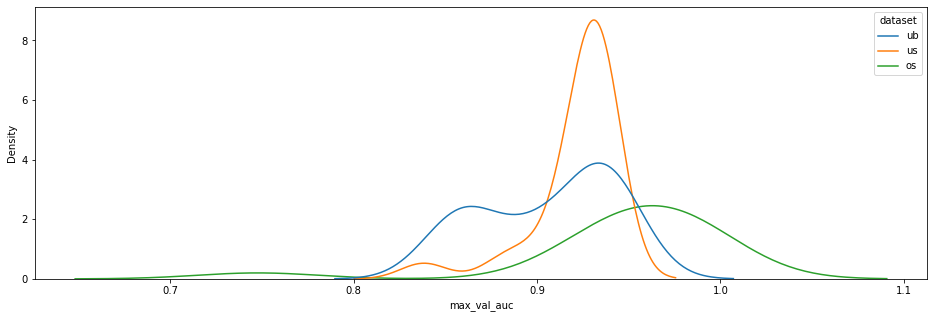

In [52]:
plt.figure(figsize=(16,5))
sns.kdeplot(data = model_build, x = 'max_val_auc', hue = 'dataset')
plt.show()

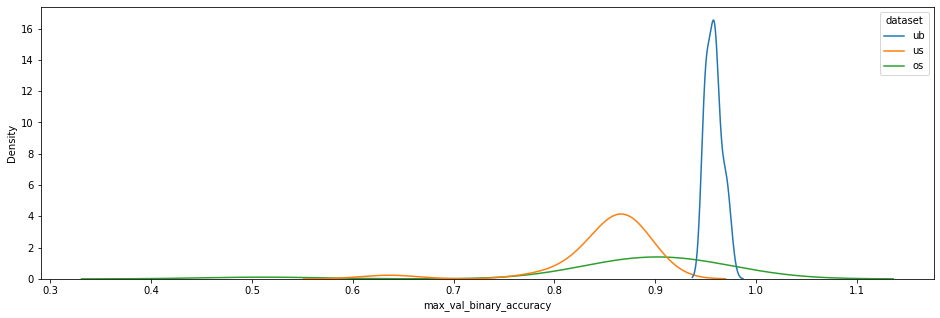

In [51]:
plt.figure(figsize=(16,5))
ax = sns.kdeplot(data = model_build, x = 'max_val_binary_accuracy', hue = 'dataset')
plt.show()

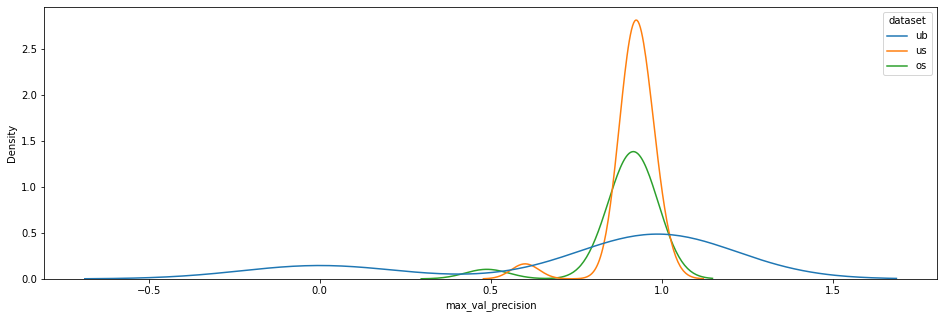

In [53]:
plt.figure(figsize=(16,5))
sns.kdeplot(data = model_build, x = 'max_val_precision', hue = 'dataset')
plt.show()

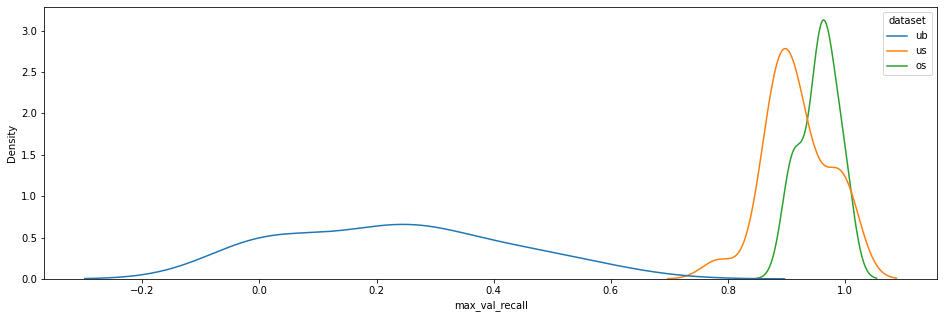

In [54]:
plt.figure(figsize=(16,5))
sns.kdeplot(data = model_build, x = 'max_val_recall', hue = 'dataset')
plt.show()

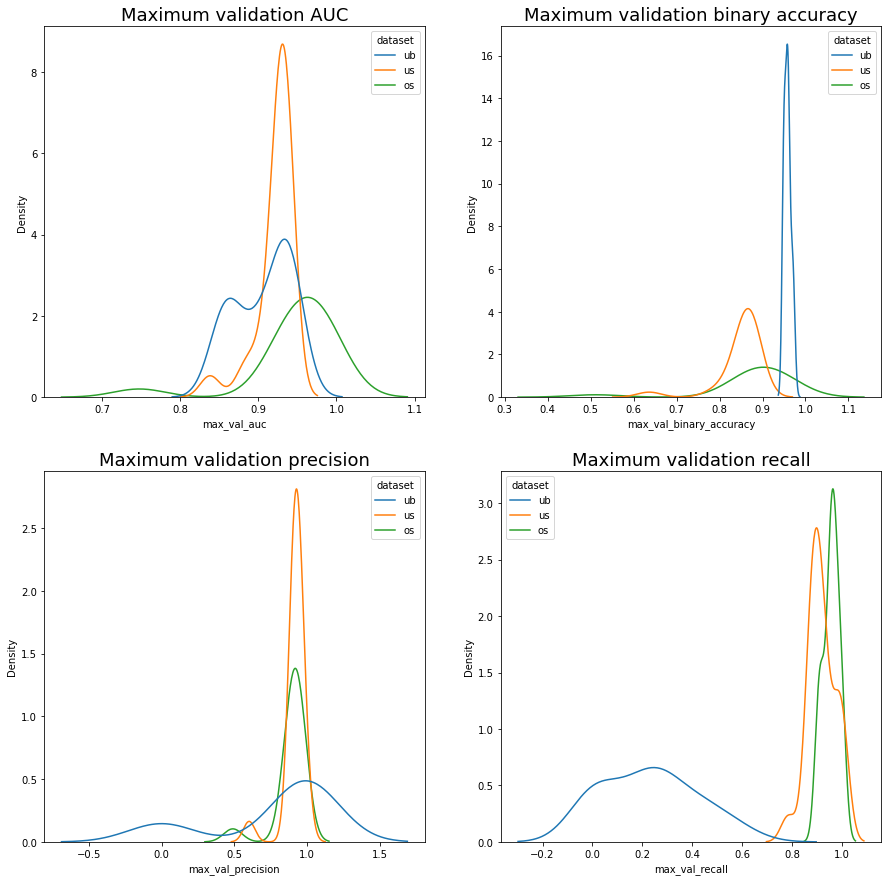

In [59]:
fig = plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
ax = sns.kdeplot(data = model_build, x = 'max_val_auc', hue = 'dataset')
ax.set_title('Maximum validation AUC', size=18)

plt.subplot(2, 2, 2)
ax = sns.kdeplot(data = model_build, x = 'max_val_binary_accuracy', hue = 'dataset')
ax.set_title('Maximum validation binary accuracy', size=18)

plt.subplot(2, 2, 3)
ax = sns.kdeplot(data = model_build, x = 'max_val_precision', hue = 'dataset')
ax.set_title('Maximum validation precision', size=18)

plt.subplot(2, 2, 4)
ax = sns.kdeplot(data = model_build, x = 'max_val_recall', hue = 'dataset')
ax.set_title('Maximum validation recall', size=18)

plt.show()

# Test data

## Random Forest

The model which achieved the highest F1 score had the parameters: {'n_estimators': 350, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}

In [64]:
bow_test_x = bow_test.drop('fraudulent', axis=1)
bow_test_y = bow_test['fraudulent']

In [65]:
rf_class = RandomForestClassifier(random_state = 100, n_jobs = -1, n_estimators=350, min_samples_split=4, 
                                  min_samples_leaf=1, bootstrap=False)

# Fit the classifier
rf_class.fit(bow_train_x_us, bow_train_y_us)

# Predict the test data
rf_preds = rf_class.predict(bow_test_x)

In [72]:
confusion_matrix(bow_test_y, rf_preds)

array([[4765,  339],
       [  19,  241]], dtype=int64)

In [75]:
f1_score(bow_test_y, rf_preds)

0.5738095238095238

In [76]:
precision_score(bow_test_y, rf_preds)

0.41551724137931034

In [77]:
recall_score(bow_test_y, rf_preds)

0.926923076923077

## Neural networks

The model which achieved the highest AUC score was model 37:

In [56]:
model_build.iloc[37, :]

ID                               37
dataset                          os
layer_size                       37
reg_type                        NaN
reg_amount                      0.0
act                            relu
dropout                       False
do_amt                          0.0
batch                            49
lr                         0.006925
max_val_binary_accuracy    0.956129
max_val_auc                0.991163
max_val_precision          0.956747
max_val_recall             0.995708
Name: 37, dtype: object

Validation metrics were highest at epoch 13:

In [91]:
model_metric_epoch[model_metric_epoch['ID']==37]

,ID,Epoch,loss,binary_accuracy,auc,precision,recall,true_positives,true_negatives,false_positives,false_negatives,val_loss,val_binary_accuracy,val_auc,val_precision,val_recall,val_true_positives,val_true_negatives,val_false_positives,val_false_negatives
955,37.0,1.0,0.287116,0.875567,0.945579,0.851706,0.909488,10832.0,10024.0,1886.0,1078.0,0.226745,0.903233,0.968049,0.897829,0.905150,2109.0,2194.0,240.0,221.0
956,37.0,2.0,0.209134,0.911262,0.972952,0.901149,0.924948,8861.0,8504.0,972.0,719.0,0.189681,0.926742,0.978083,0.903134,0.952361,2219.0,2196.0,238.0,111.0
957,37.0,3.0,0.178519,0.924643,0.979994,0.914833,0.937370,8980.0,8640.0,836.0,600.0,0.182085,0.923384,0.981267,0.942368,0.898283,2093.0,2306.0,128.0,237.0
958,37.0,4.0,0.159196,0.932200,0.983920,0.923982,0.942693,9031.0,8733.0,743.0,549.0,0.155965,0.938497,0.983796,0.911848,0.967811,2255.0,2216.0,218.0,75.0
959,37.0,5.0,0.144224,0.938182,0.986685,0.930342,0.948017,9082.0,8796.0,680.0,498.0,0.152031,0.934929,0.984348,0.917011,0.953219,2221.0,2233.0,201.0,109.0
960,37.0,6.0,0.134960,0.941068,0.988202,0.932849,0.951253,9113.0,8820.0,656.0,467.0,0.142636,0.942485,0.986129,0.934856,0.948498,2210.0,2280.0,154.0,120.0
961,37.0,7.0,0.126548,0.945267,0.989566,0.935873,0.956681,9165.0,8848.0,628.0,415.0,0.134063,0.948363,0.987371,0.921521,0.977682,2278.0,2240.0,194.0,52.0
962,37.0,8.0,0.121902,0.945581,0.990297,0.932995,0.960752,9204.0,8815.0,661.0,376.0,0.130513,0.948153,0.988671,0.917435,0.982403,2289.0,2228.0,206.0,41.0
963,37.0,9.0,0.116756,0.950724,0.991134,0.939567,0.963987,9235.0,8882.0,594.0,345.0,0.122108,0.947313,0.989867,0.916300,0.981974,2288.0,2225.0,209.0,42.0
964,37.0,10.0,0.113910,0.949780,0.991462,0.938740,0.962944,9225.0,8874.0,602.0,355.0,0.117695,0.954240,0.990358,0.931373,0.978541,2280.0,2266.0,168.0,50.0


Define the model:

In [90]:
first_layer_size = 37

desc_input = Input(shape=(il_desc), dtype='int32', name='desc')
embedded_desc = layers.Embedding(nt_desc, ed_desc, input_length=il_desc,
                                weights=[em_desc], trainable=False)(desc_input)
flat_desc = layers.Flatten()(embedded_desc)
dense_desc = layers.Dense(first_layer_size, activation='relu')(flat_desc)

title_input = Input(shape=(il_title), dtype='int32', name='title')
embedded_title = layers.Embedding(nt_title, ed_title, input_length=il_title,
                                weights=[em_title], trainable=False)(title_input)
flat_title = layers.Flatten()(embedded_title)
dense_title = layers.Dense(first_layer_size, activation='relu')(flat_title)

cp_input = Input(shape=(il_cp), dtype='int32', name='cp')
embedded_cp = layers.Embedding(nt_cp, ed_cp, input_length=il_cp,
                                weights=[em_cp], trainable=False)(cp_input)
flat_cp = layers.Flatten()(embedded_cp)
dense_cp = layers.Dense(first_layer_size, activation='relu')(flat_cp)

reqs_input = Input(shape=(il_reqs), dtype='int32', name='reqs')
embedded_reqs = layers.Embedding(nt_reqs, ed_reqs, input_length=il_reqs,
                                weights=[em_reqs], trainable=False)(reqs_input)
flat_reqs = layers.Flatten()(embedded_reqs)
dense_reqs = layers.Dense(first_layer_size, activation='relu')(flat_reqs)

benefits_input = Input(shape=(il_benefits), dtype='int32', name='benefits')
embedded_benefits = layers.Embedding(nt_benefits, ed_benefits, input_length=il_benefits,
                                weights=[em_benefits], trainable=False)(benefits_input)
flat_benefits = layers.Flatten()(embedded_benefits)
dense_benefits = layers.Dense(first_layer_size, activation='relu')(flat_benefits)

# Non-text features: feed directly into first dense layer
nontext_input = Input(shape=(il_nt), dtype='float64',name='nontext')
dense_nontext = layers.Dense(first_layer_size, activation='relu')(nontext_input)

# Concatenate
concatenated = layers.concatenate([dense_desc, dense_title, dense_cp, dense_reqs, dense_benefits, dense_nontext], axis=-1)

# Output layer
output = layers.Dense(1, activation='sigmoid')(concatenated)

# Define model
model = Model([desc_input, title_input, cp_input, reqs_input, benefits_input, nontext_input], output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
desc (InputLayer)               [(None, 655)]        0                                            
__________________________________________________________________________________________________
title (InputLayer)              [(None, 15)]         0                                            
__________________________________________________________________________________________________
cp (InputLayer)                 [(None, 528)]        0                                            
__________________________________________________________________________________________________
reqs (InputLayer)               [(None, 615)]        0                                            
______________________________________________________________________________________________

In [98]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=0.006925), loss='binary_crossentropy', metrics=model_metrics)
model.fit(train_input_os, train_y_os, epochs=13, batch_size=49)

Epoch 1/13
389/389 [==============================] - 51s 114ms/step - loss: 0.1099 - binary_accuracy: 0.9722 - auc: 0.9944 - precision: 0.9681 - recall: 0.9769 - true_positives: 9359.0000 - true_negatives: 9168.0000 - false_positives: 308.0000 - false_negatives: 221.0000
Epoch 2/13
389/389 [==============================] - 41s 105ms/step - loss: 0.0042 - binary_accuracy: 0.9988 - auc: 0.9997 - precision: 0.9990 - recall: 0.9986 - true_positives: 9567.0000 - true_negatives: 9466.0000 - false_positives: 10.0000 - false_negatives: 13.00001s -  - ETA: 6s - loss: 0.0050 - binary_accuracy: 0.9986 - auc: 0.9997 - precision: 0.9988 - 
Epoch 3/13
389/389 [==============================] - 47s 121ms/step - loss: 8.0552e-07 - binary_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - true_positives: 9580.0000 - true_negatives: 9476.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 11s - loss: 1.0545e-06 - binary_a
Epoch 4/13
389/389 [============================

In [99]:
# Test data
test_input = {'desc': test_desc_df, 'title': test_title_df, 'cp': test_cp_df, 'reqs': test_reqs_df, 
            'benefits': test_benefits_df, 'nontext': test_nt.drop('fraudulent', axis=1)}
test_y = test_nt['fraudulent']

In [101]:
test_metrics = model.evaluate(test_input, test_y, batch_size=49)

110/110 [==============================] - 4s 27ms/step - loss: 0.3837 - binary_accuracy: 0.9823 - auc: 0.8459 - precision: 0.9825 - recall: 0.6462 - true_positives: 168.0000 - true_negatives: 5101.0000 - false_positives: 3.0000 - false_negatives: 92.0000


In [110]:
for i in range(len(model_metrics)):
    print(model_metrics[i].name, '      ', test_metrics[i+1])
print('loss      ', test_metrics[0])

binary_accuracy        0.9822893142700195
auc        0.8459040522575378
precision        0.9824561476707458
recall        0.6461538672447205
true_positives        168.0
true_negatives        5101.0
false_positives        3.0
false_negatives        92.0
loss       0.38365915417671204
